# Exercise 10
## Lars Kühmichel, Nicolas Wolf

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import time

In [10]:
plt.rc("figure", dpi=150)
plt.rc("legend", fontsize=6)

device = "cuda"

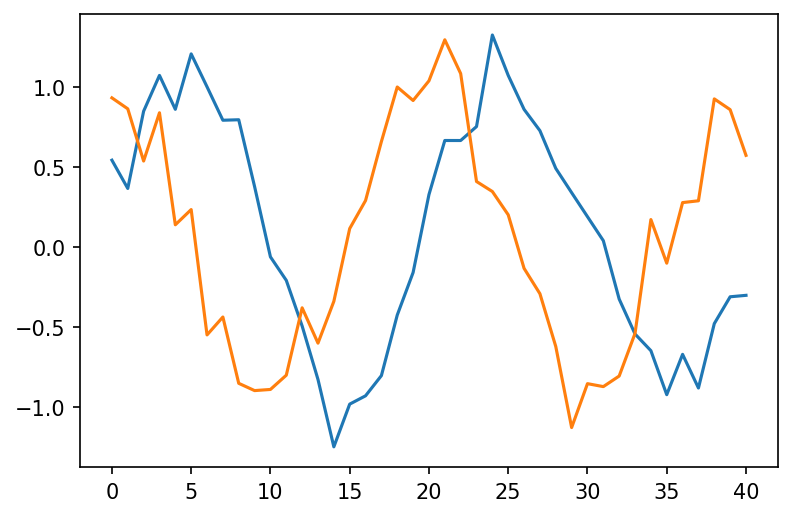

In [29]:
data = torch.load('noisy_sinus.pt')
observation_size = data.shape[1]

plt.plot(data)
#plt.savefig('inputData', dpi=500)
#plt.close()
plt.show()

In [34]:
class latent_RNN(nn.Module):
    def __init__(self, obs_dim, latent_dim, p_dropout=0.0):
        super().__init__()
        self.obs_dim = obs_dim
        self.latent_dim = latent_dim
        
        self.U = nn.Parameter(torch.empty(size=(latent_dim, obs_dim)))
        self.V = nn.Parameter(torch.empty(size=(latent_dim, latent_dim)))
        self.bias_hidden = nn.Parameter(torch.empty(size=(latent_dim,)))
        self.W = nn.Parameter(torch.empty(size=(obs_dim, latent_dim)))
        self.bias_output = nn.Parameter(torch.empty(size=(obs_dim,)))
        
        k = np.sqrt(1/latent_dim)
        for p in self.parameters():
            nn.init.uniform_(p, -k, k)

        
        self.dropout_layer = nn.Dropout(p_dropout)
        

    def forward(self, time_series, h0):
        T = time_series.shape[0]
        # time_series.shape == (T, batch_size, observation_size)
        # h0.shape == (batch_size, hidden_size)
        
        x = torch.zeros(size=time_series.shape, device=device)
        h = h0
        for t in range(T):
            h = torch.tanh(time_series[t] @ self.U.T + h @ self.V.T + self.bias_hidden)
            x[t] = self.dropout_layer(h) @ self.W.T + self.bias_output
            
        return x, h
    
    def L1_regularization(self):
        return sum([torch.sum(torch.abs(param)) for param in self.parameters()])
    
    def L2_regularization(self):
        return sum([torch.sum(torch.square(param)) for param in self.parameters()])
        
def train(model, optimizer, loss_function, epochs, hidden_size, batch_size=None):
    losses = np.zeros(epochs)
    
    pbar = tqdm(range(epochs))
    for i in pbar:
        h0 = torch.randn((1, hidden_size), device=device)
        x = data[:-1]  #x_0:T-1
        y = data[1:]   #x_1:T
                
        if batch_size is not None and 1 <= batch_size < len(x):
            num_batches = len(data) // batch_size
            start_indices = np.random.randint(0, len(x)-batch_size, num_batches)
            x_batches = torch.zeros(size=(batch_size, num_batches, observation_size))
            y_batches = torch.zeros(size=(batch_size, num_batches, observation_size))
            for j, index in enumerate(start_indices):
                x_batches[:,j,:] = x[index:index+batch_size]
                y_batches[:,j,:] = y[index:index+batch_size]
            x = x_batches
            y = y_batches
            h0 = torch.randn((1, num_batches, hidden_size), device=device)
        
        x = x.to(device)
        y = y.to(device)
            
        optimizer.zero_grad()               
        output, _ = model(x, h0)
        epoch_loss = loss_function(output, y)
        epoch_loss.backward()
        optimizer.step()
        
        losses[i] = epoch_loss.item()
        if i % 10 == 0:
            pbar.set_description(f"loss = {epoch_loss.item():.5f}")
            
    return losses

  0%|          | 0/500 [00:00<?, ?it/s]

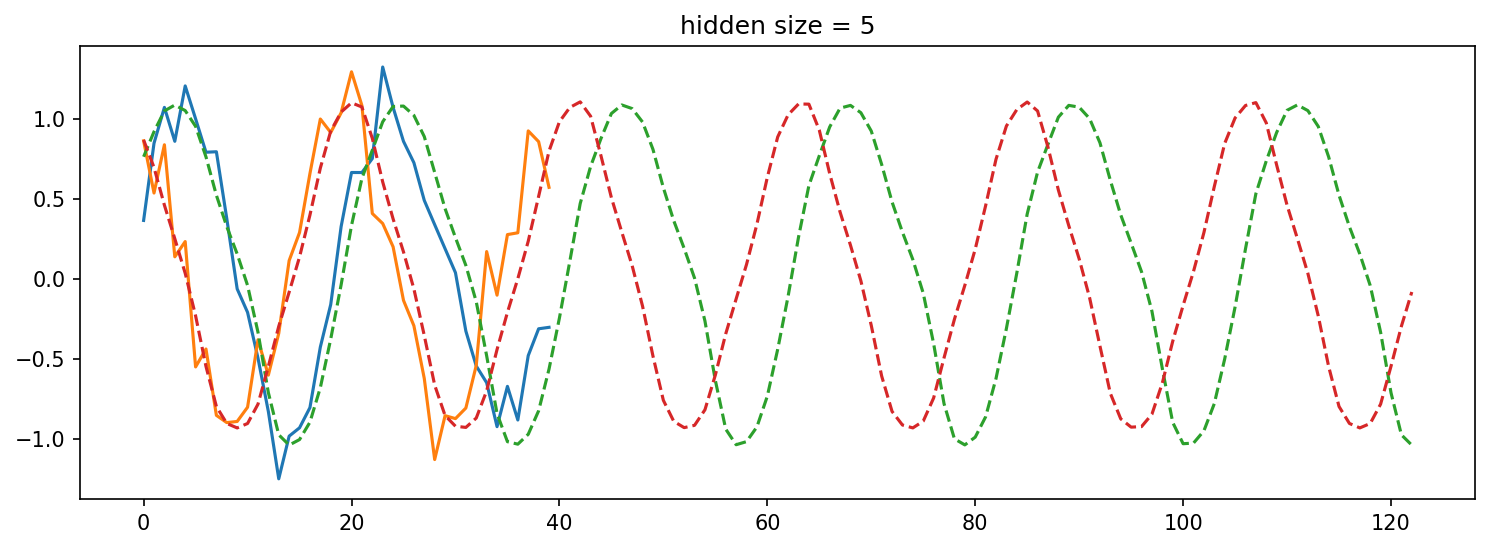

  0%|          | 0/500 [00:00<?, ?it/s]

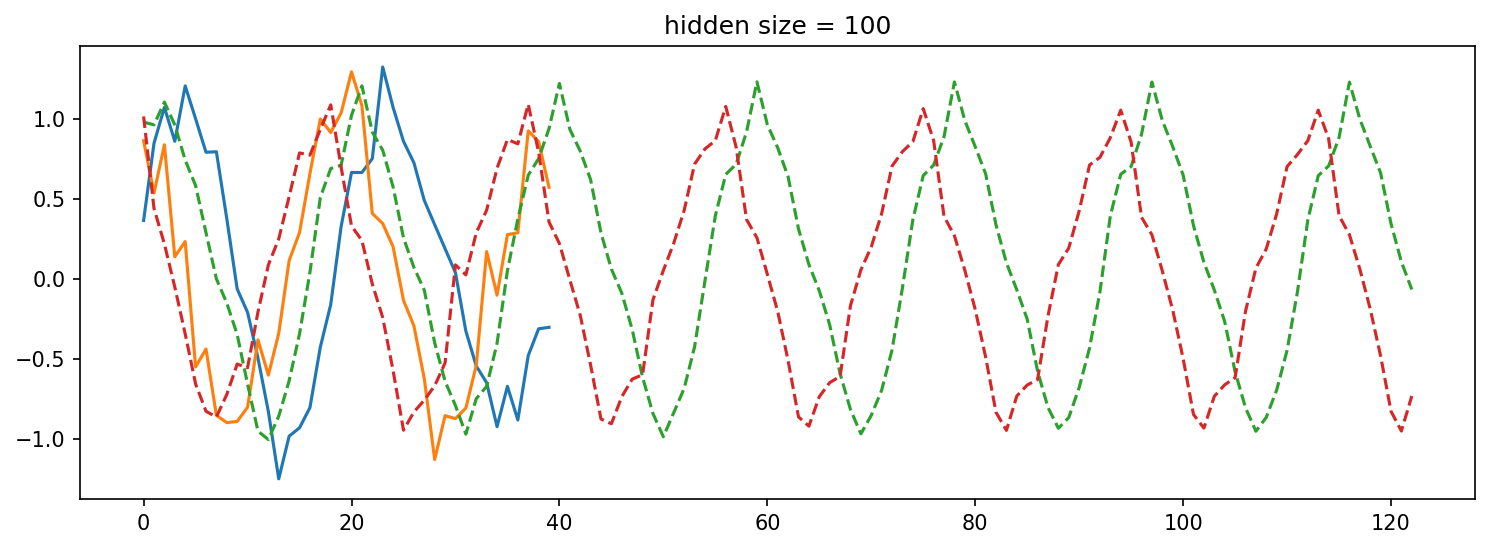

  0%|          | 0/500 [00:00<?, ?it/s]

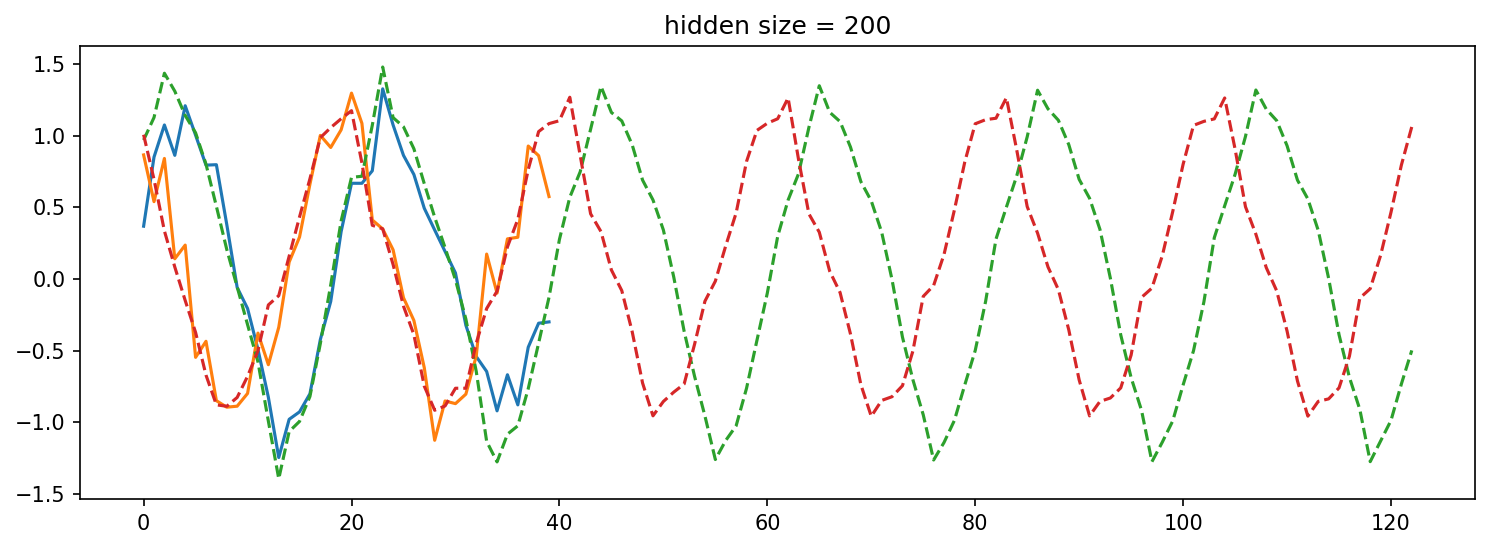

  0%|          | 0/500 [00:00<?, ?it/s]

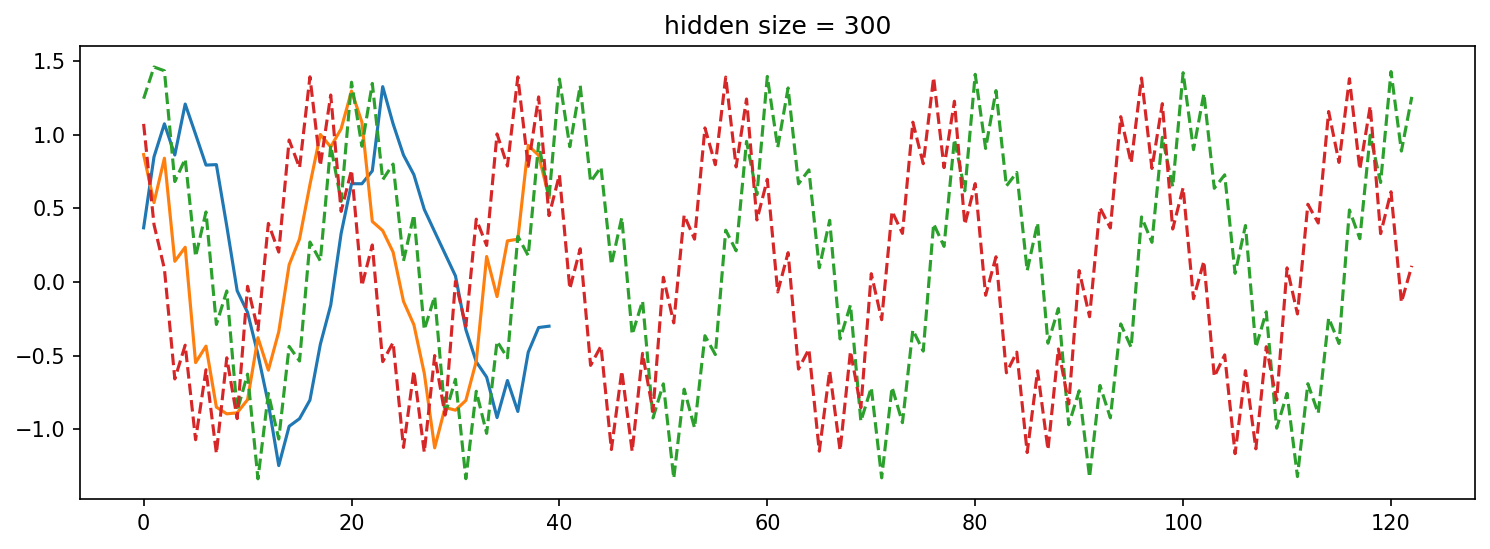

  0%|          | 0/500 [00:00<?, ?it/s]

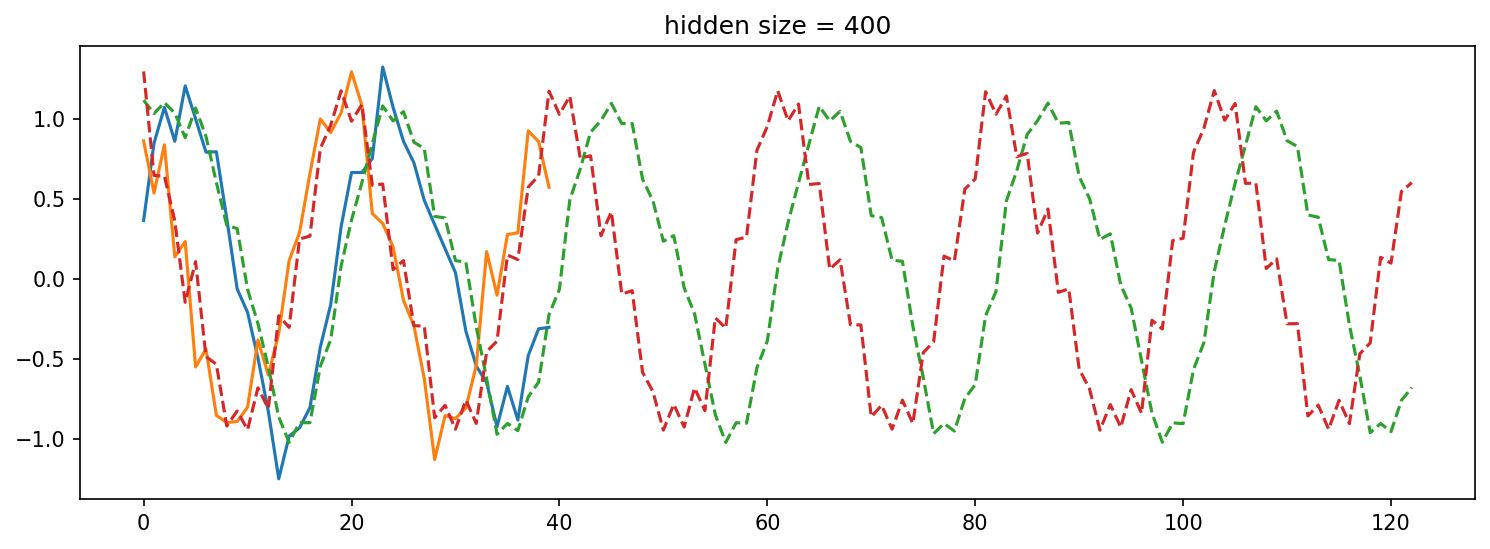

  0%|          | 0/500 [00:00<?, ?it/s]

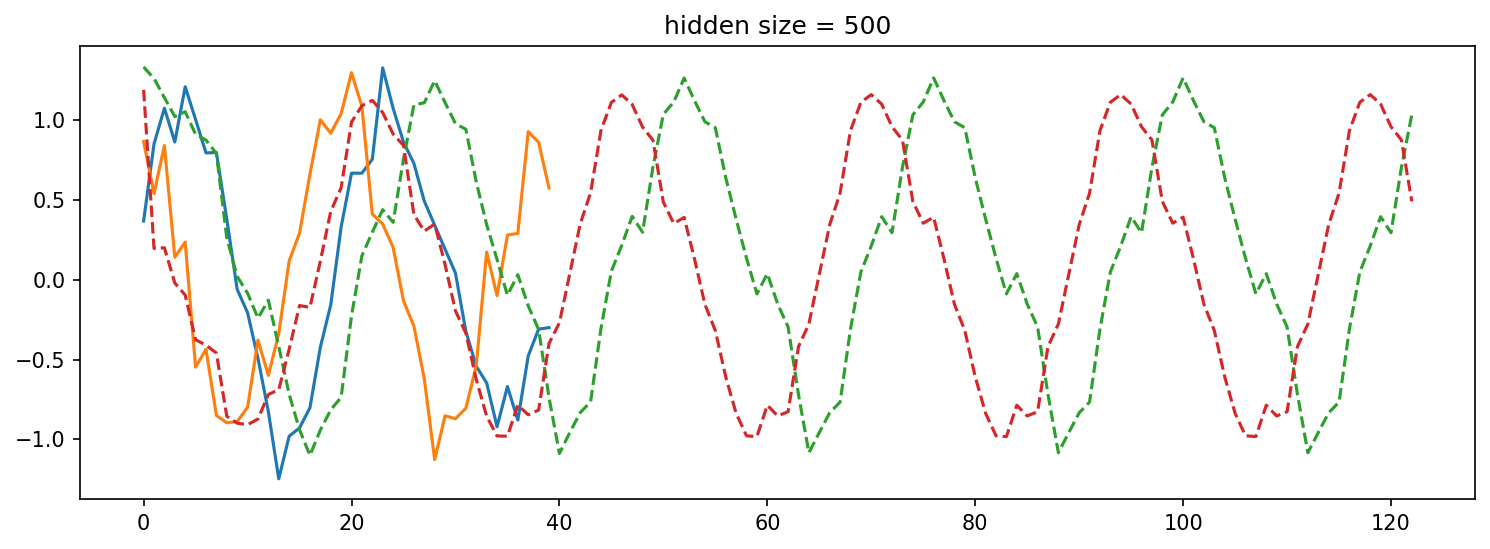

  0%|          | 0/500 [00:00<?, ?it/s]

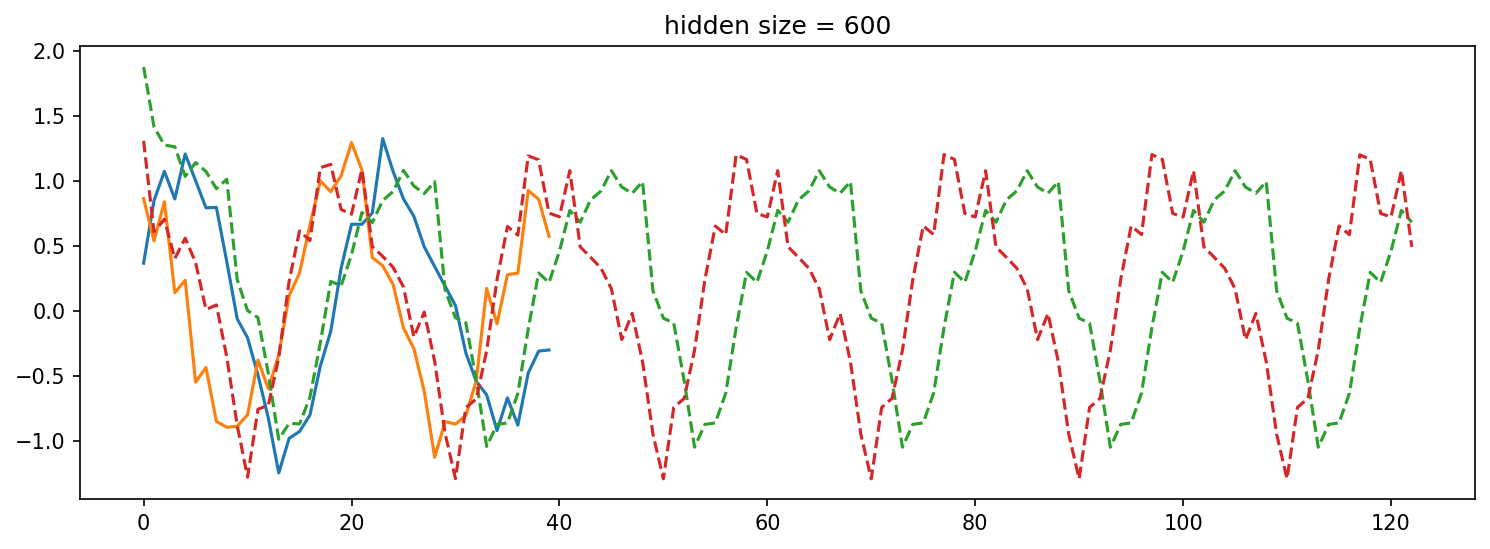

  0%|          | 0/500 [00:00<?, ?it/s]

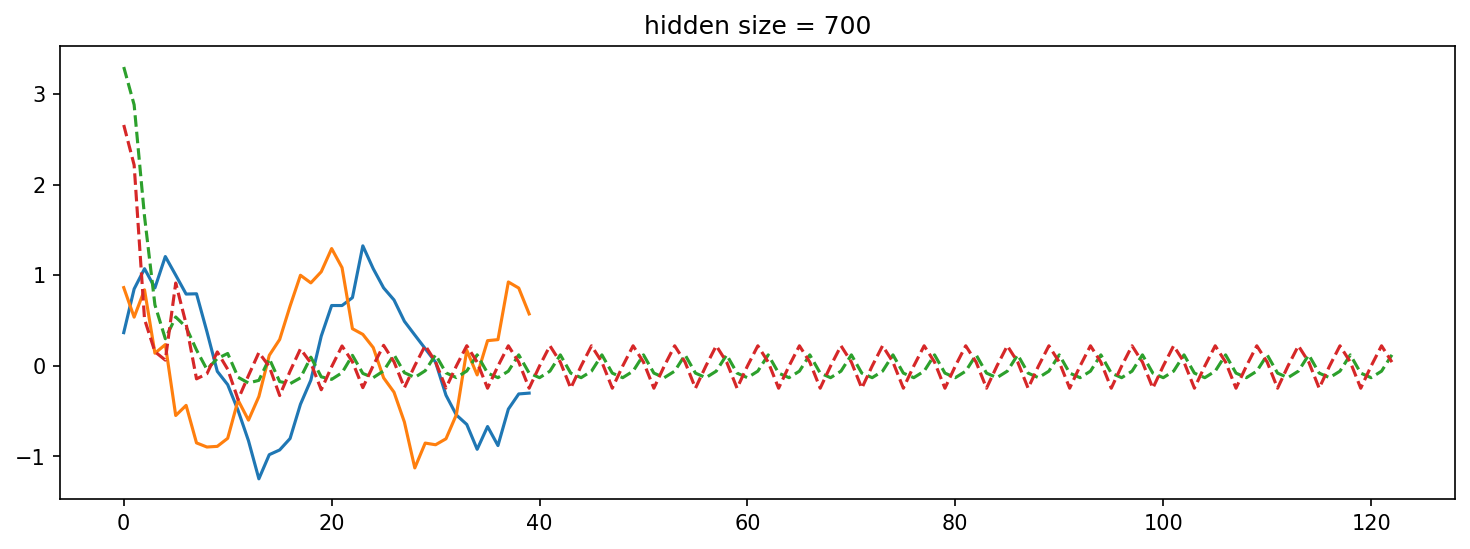

  0%|          | 0/500 [00:00<?, ?it/s]

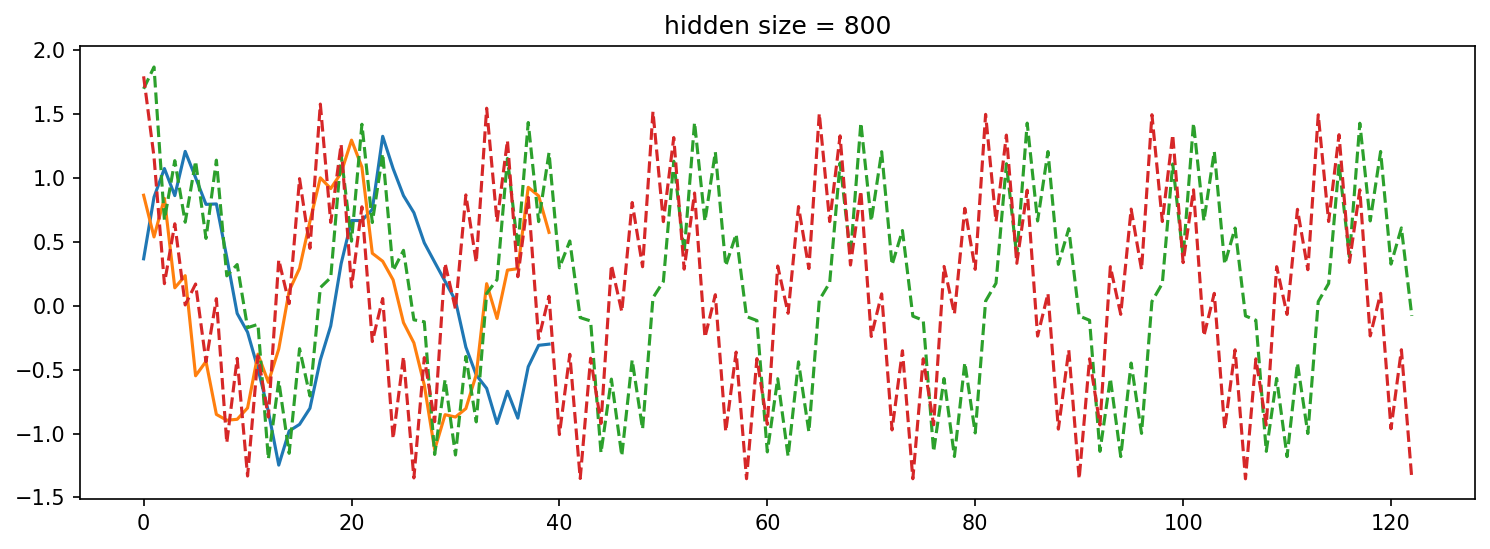

  0%|          | 0/500 [00:00<?, ?it/s]

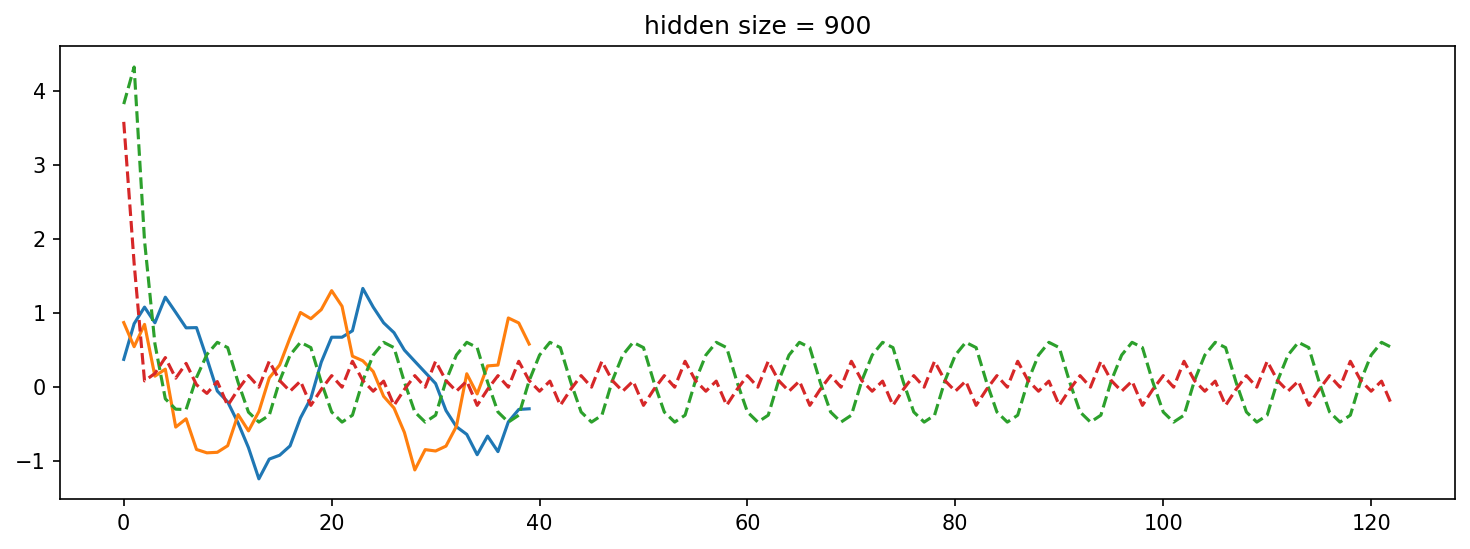

  0%|          | 0/500 [00:00<?, ?it/s]

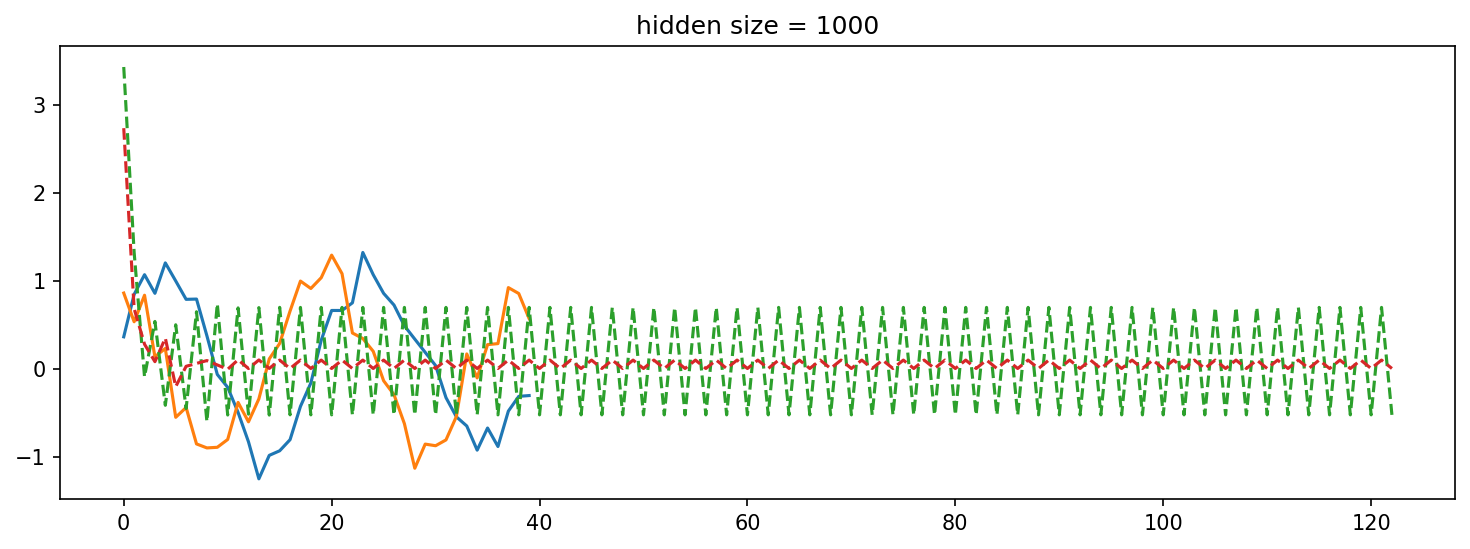

In [45]:
def find_overfitting_hidden_size():
    epochs = 500
    learning_rate = 0.01
    
    hidden_sizes = np.insert(np.arange(100, 1000+1, 100), 0, 5)
    for hidden_size in hidden_sizes:
        model = latent_RNN(observation_size, hidden_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_function = nn.MSELoss()
        
        train(model, optimizer, loss_function, epochs, hidden_size, batch_size=16)
        
        
        with torch.no_grad():
            h = torch.zeros((1, hidden_size), device=device)
            predictions = torch.zeros((3*data.shape[0], observation_size))
            input_ = data[0:1].to(device)
            for i in range(3*data.size(0)):
                pred, h = model(input_, h)
                input_ = pred
                predictions[i] = pred.cpu()

            plt.figure(figsize=(12,4))
            plt.plot(data[1:])
            plt.plot(predictions, "--")
            #plt.xlim((0, 50))
            plt.title(f"hidden size = {hidden_size}")
            plt.show()
            #plt.savefig('Predictions', dpi=500)

find_overfitting_hidden_size()

## a) Add $L_1$-Regularization

  0%|          | 0/500 [00:00<?, ?it/s]

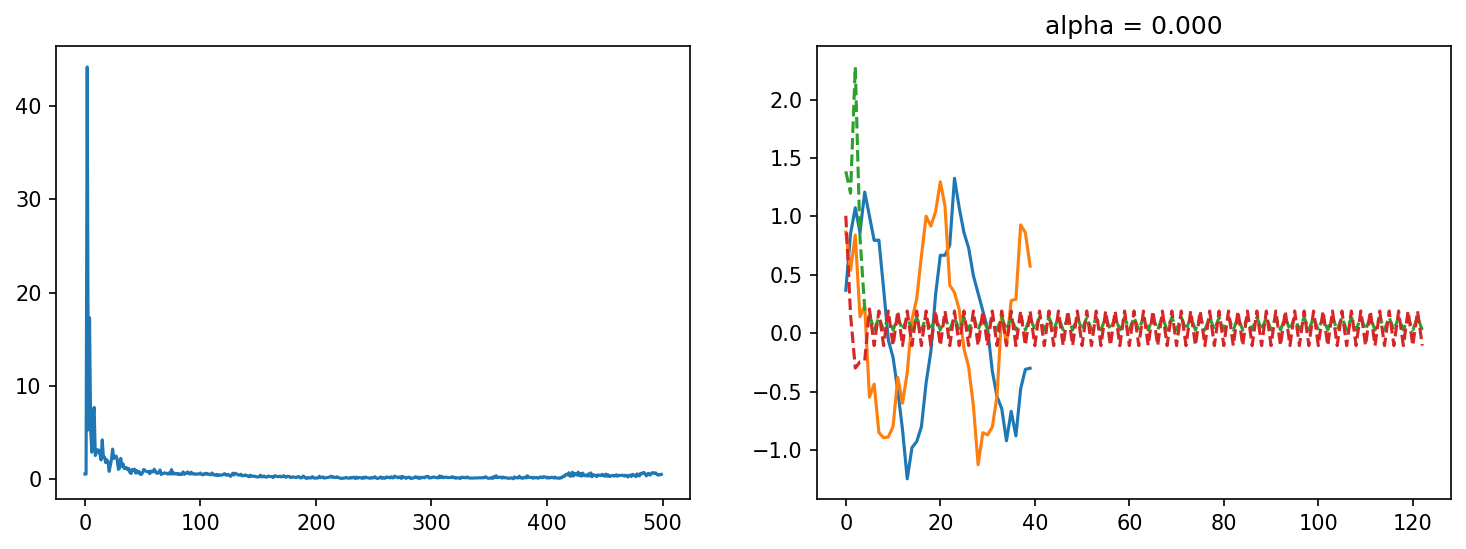

  0%|          | 0/500 [00:00<?, ?it/s]

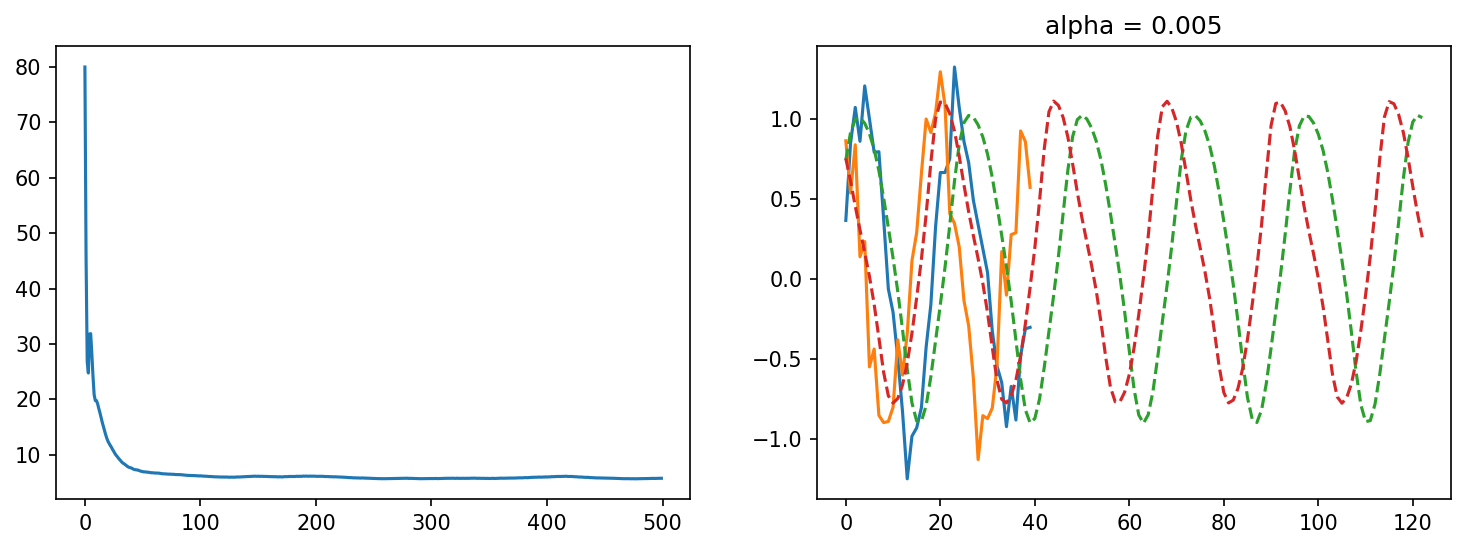

  0%|          | 0/500 [00:00<?, ?it/s]

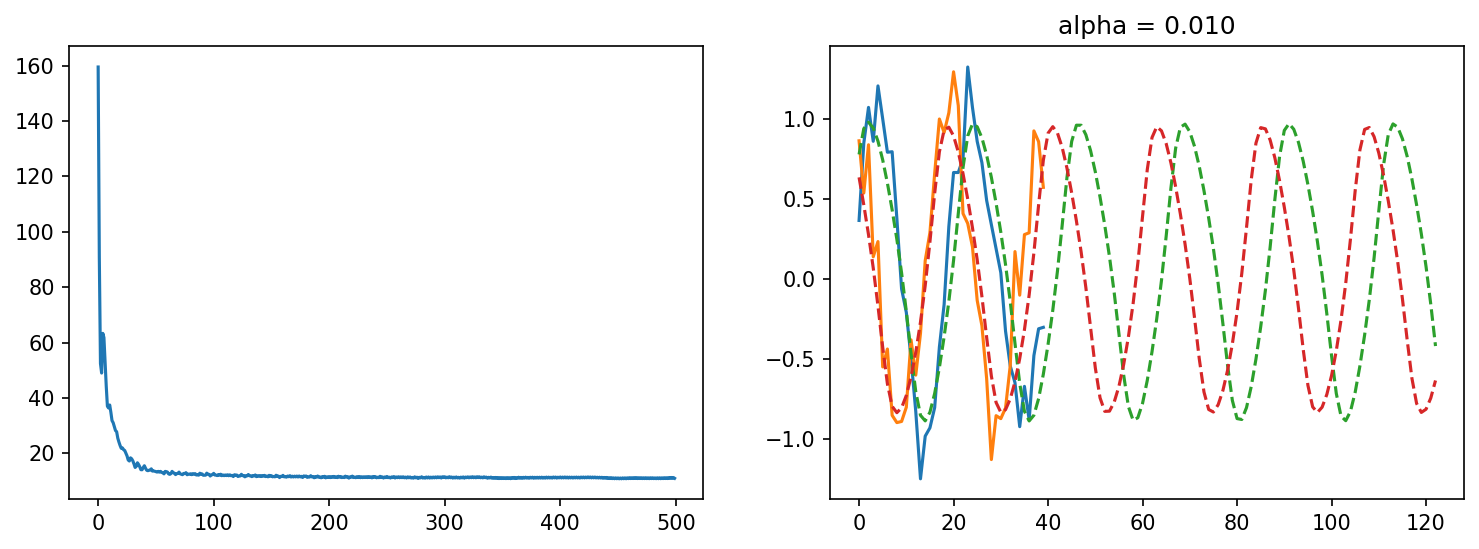

  0%|          | 0/500 [00:00<?, ?it/s]

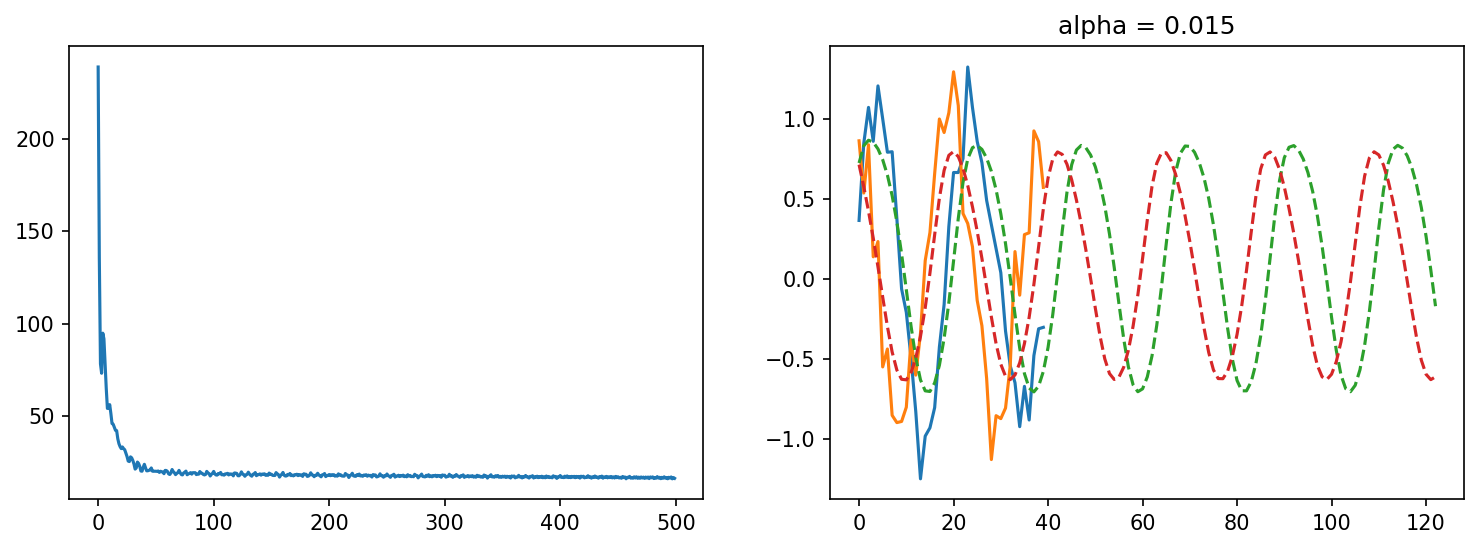

  0%|          | 0/500 [00:00<?, ?it/s]

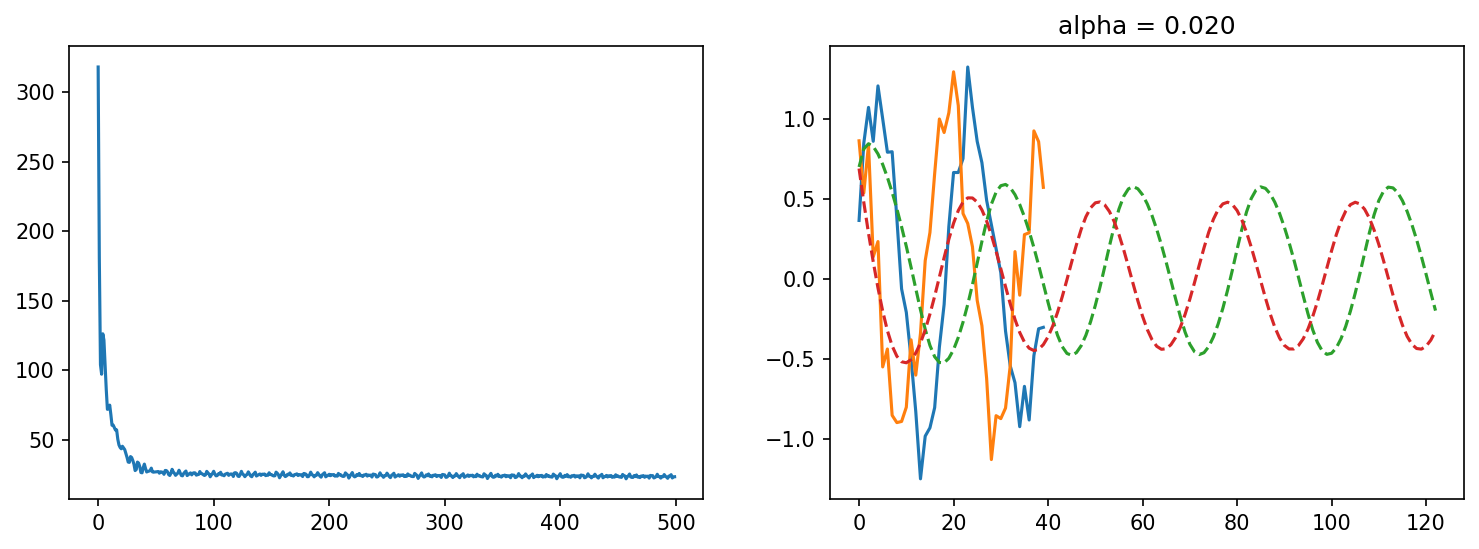

  0%|          | 0/500 [00:00<?, ?it/s]

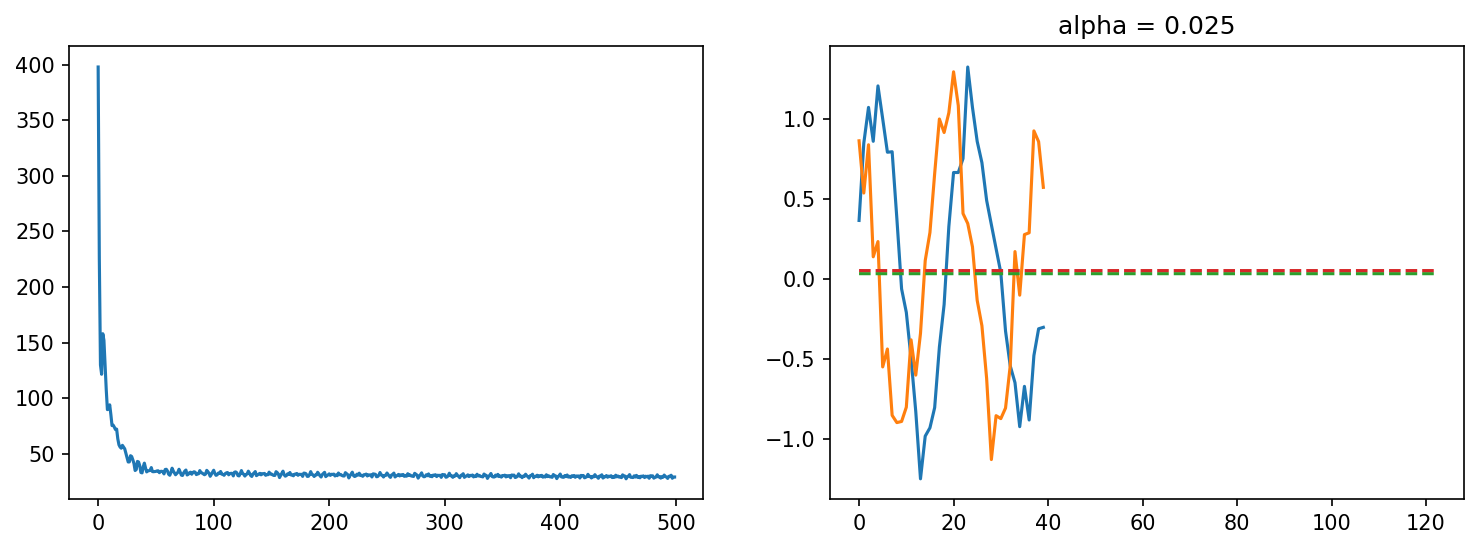

  0%|          | 0/500 [00:00<?, ?it/s]

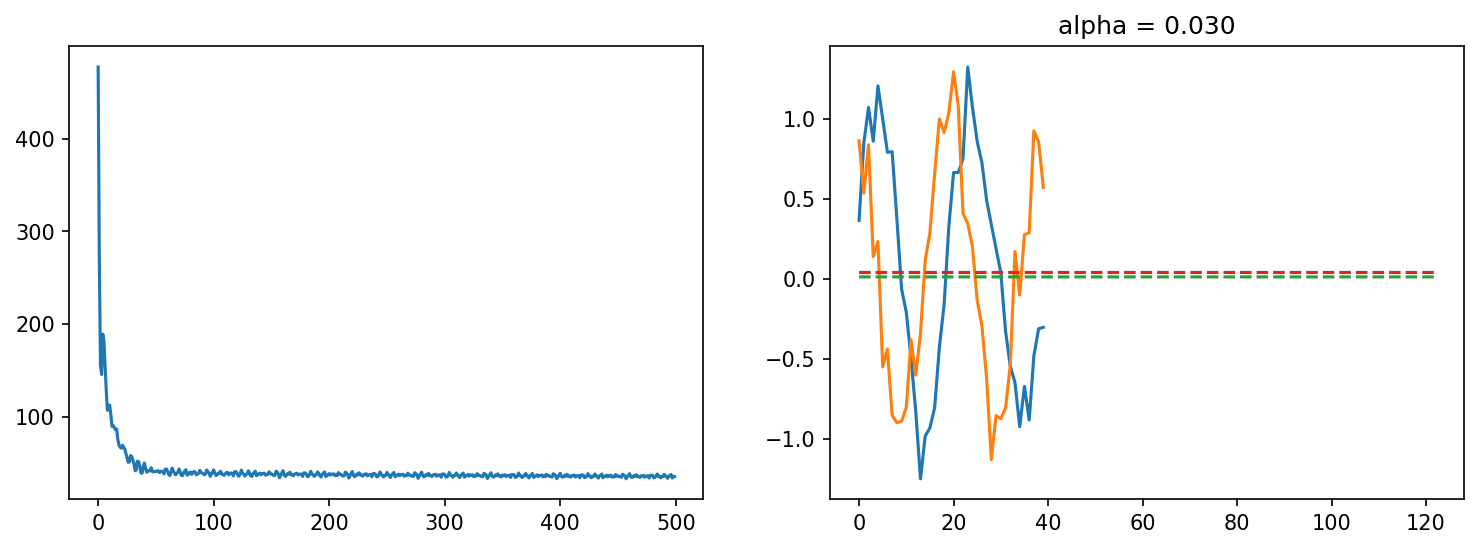

  0%|          | 0/500 [00:00<?, ?it/s]

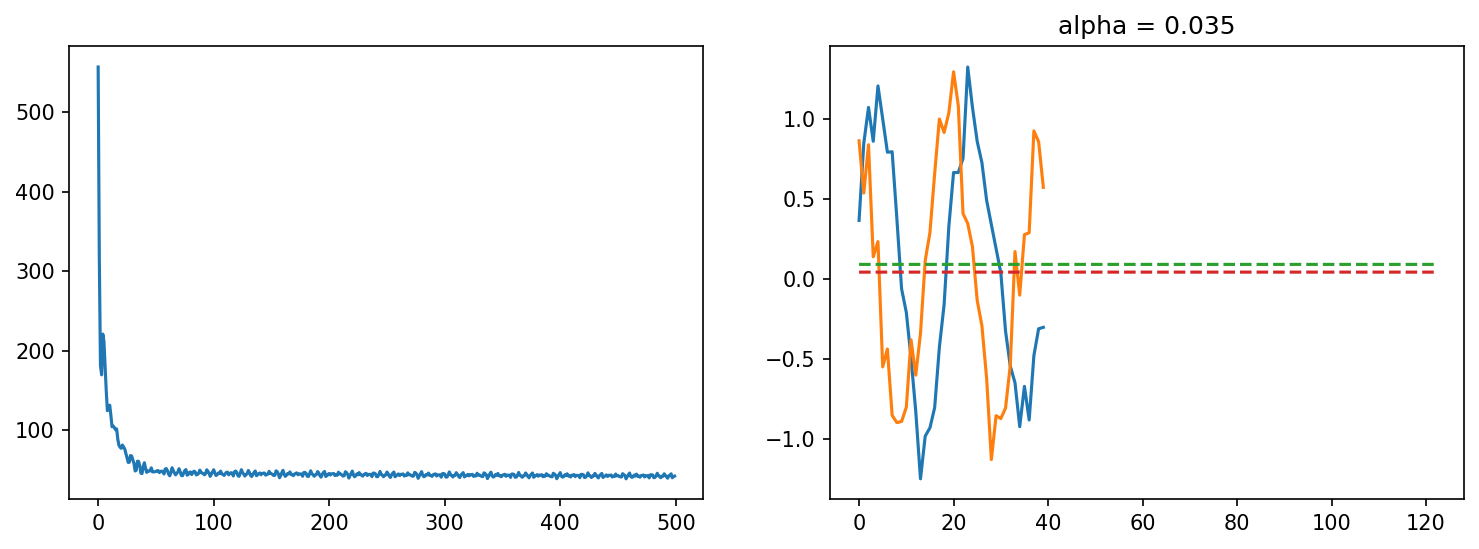

  0%|          | 0/500 [00:00<?, ?it/s]

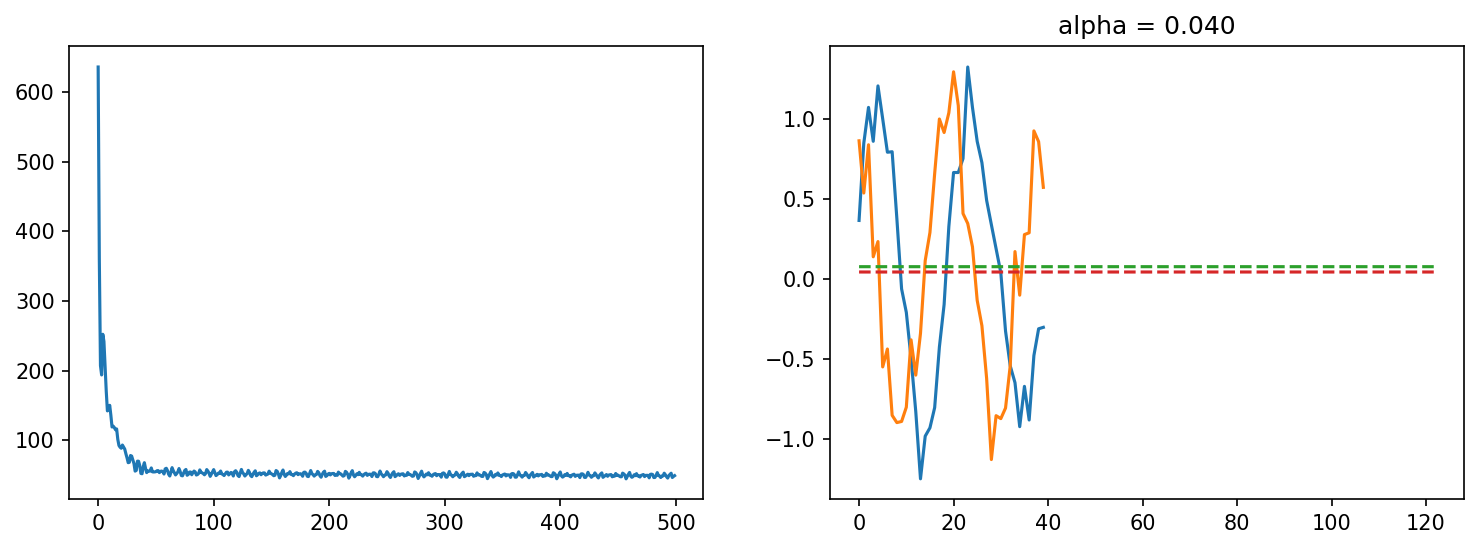

  0%|          | 0/500 [00:00<?, ?it/s]

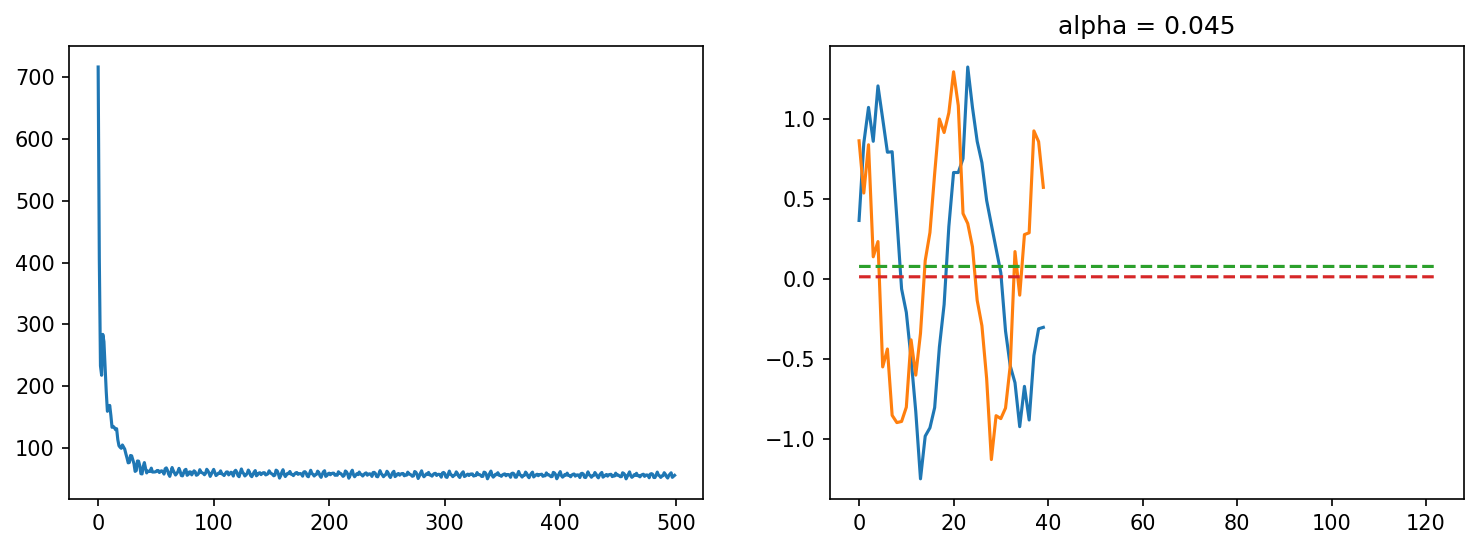

  0%|          | 0/500 [00:00<?, ?it/s]

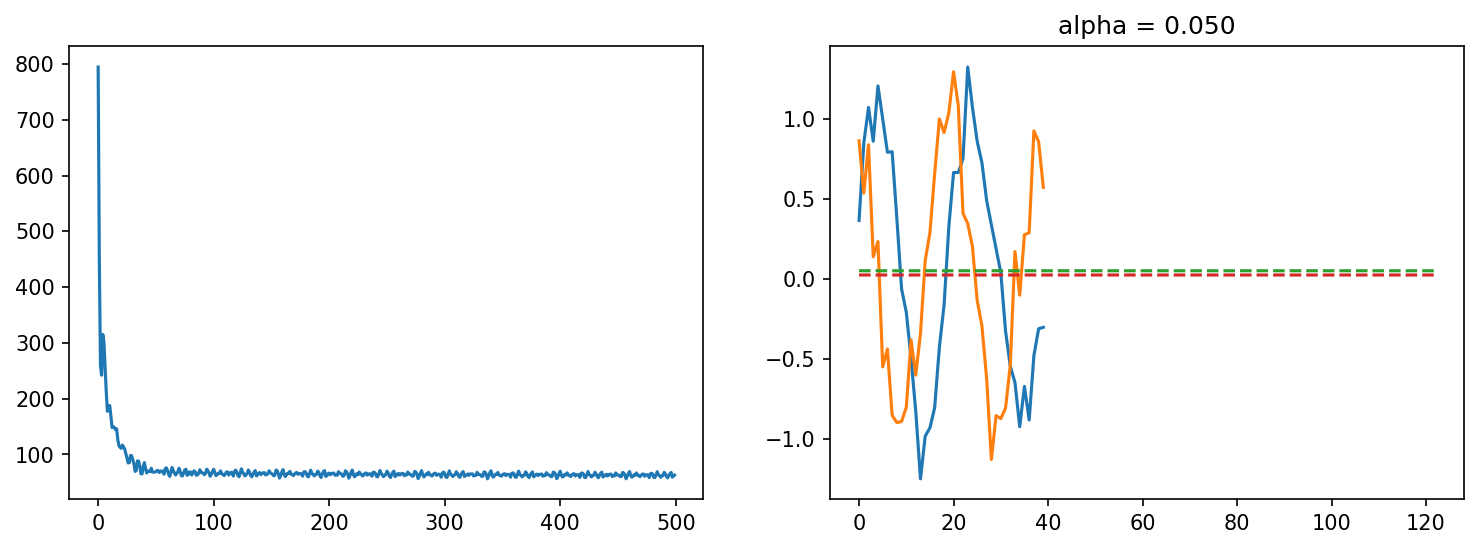

In [38]:
hidden_size = 1000
epochs = 500
learning_rate = 0.01
alphas = np.linspace(0, .05, 11)
for alpha in alphas:
    model = latent_RNN(observation_size, hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()
    loss_function = lambda output, target: mse_loss(output, target) + alpha * model.L1_regularization()
    
    losses = train(model, optimizer, loss_function, epochs, hidden_size, batch_size=16)

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(losses)
    
    with torch.no_grad():
        h = torch.zeros((1, hidden_size), device=device)
        predictions = torch.zeros((3*data.shape[0], observation_size))
        input_ = data[0:1].to(device)
        for i in range(3*data.size(0)):
            pred, h = model(input_, h)
            input_ = pred
            predictions[i] = pred.cpu()

        axes[1].plot(data[1:])
        axes[1].plot(predictions, "--")

    plt.title(f"alpha = {alpha:.3f}")
        
    plt.show()

## b) $L_2$-Regularization

  0%|          | 0/500 [00:00<?, ?it/s]

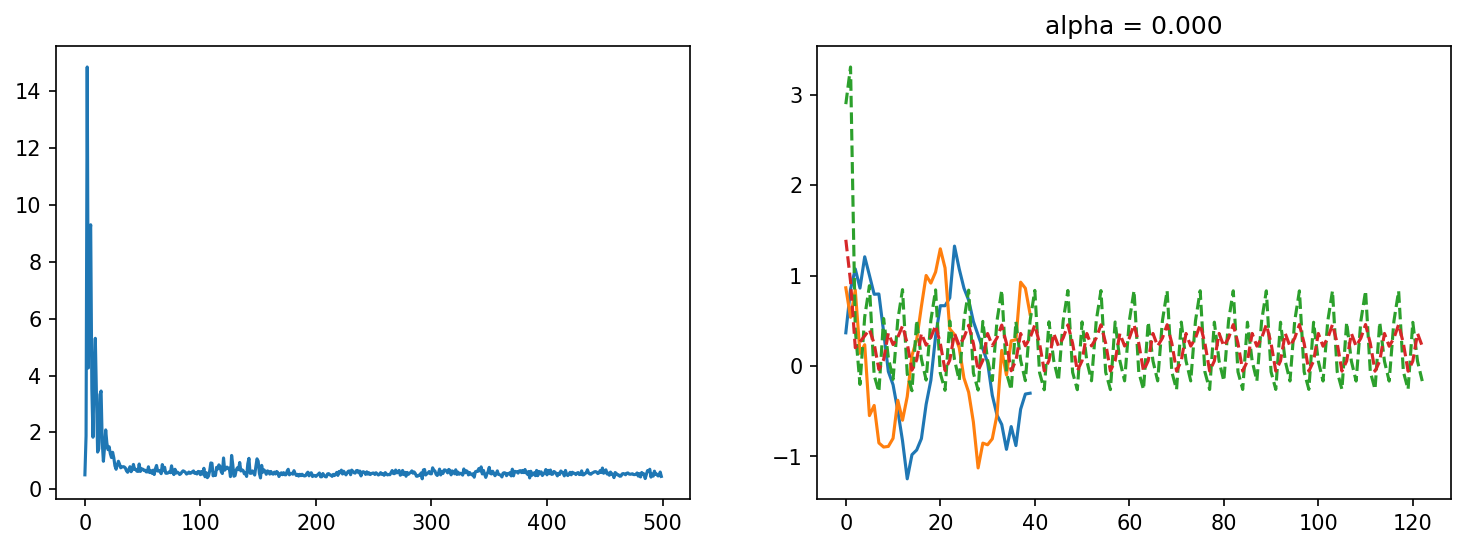

  0%|          | 0/500 [00:00<?, ?it/s]

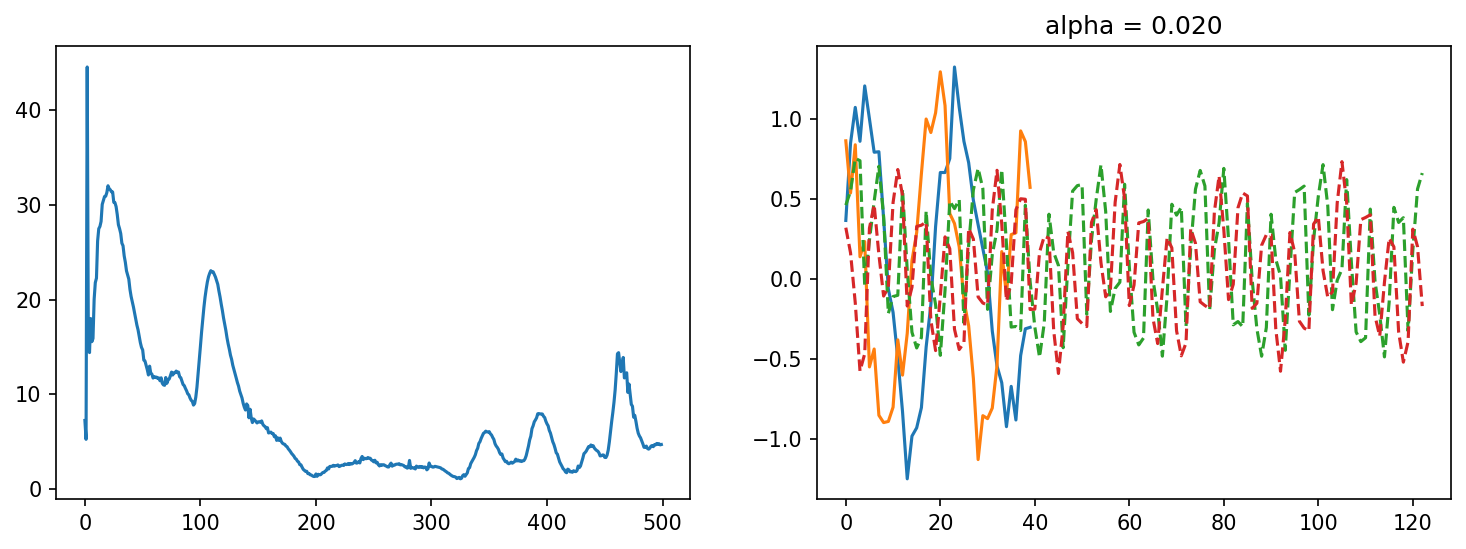

  0%|          | 0/500 [00:00<?, ?it/s]

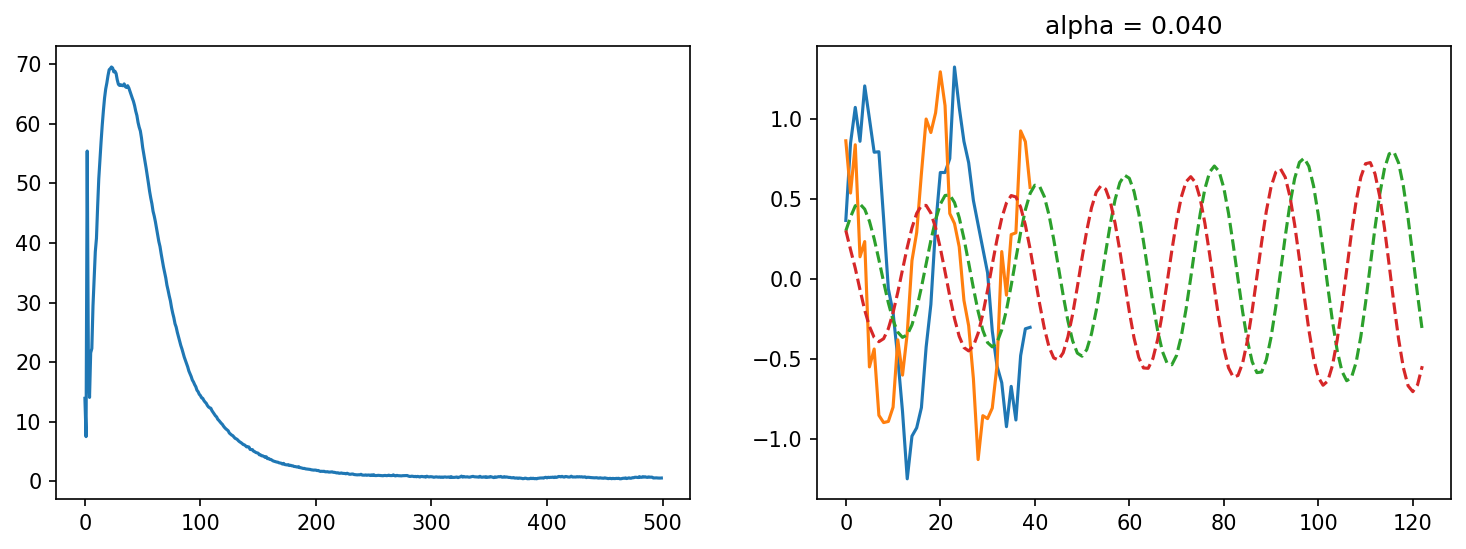

  0%|          | 0/500 [00:00<?, ?it/s]

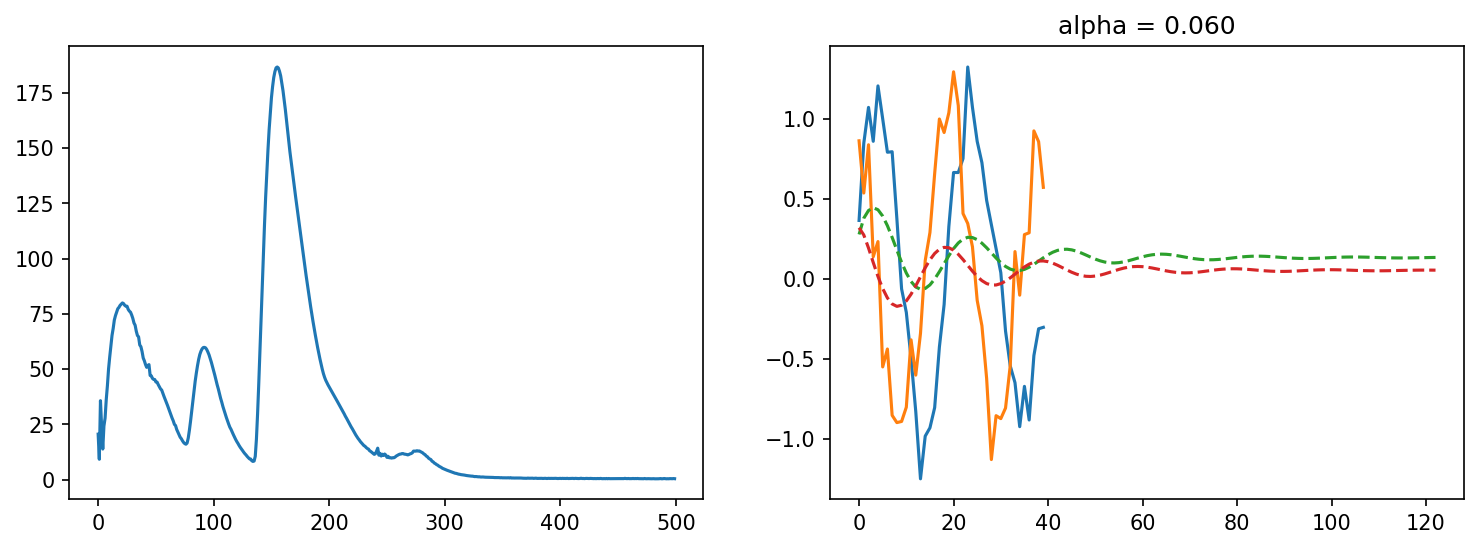

  0%|          | 0/500 [00:00<?, ?it/s]

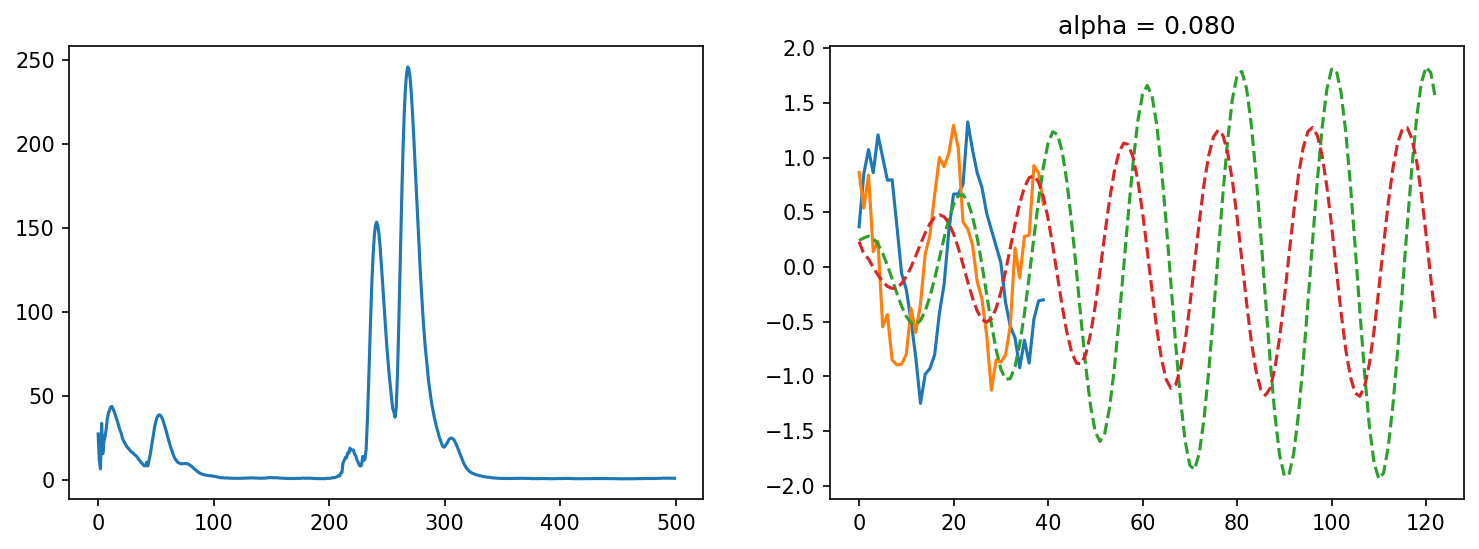

  0%|          | 0/500 [00:00<?, ?it/s]

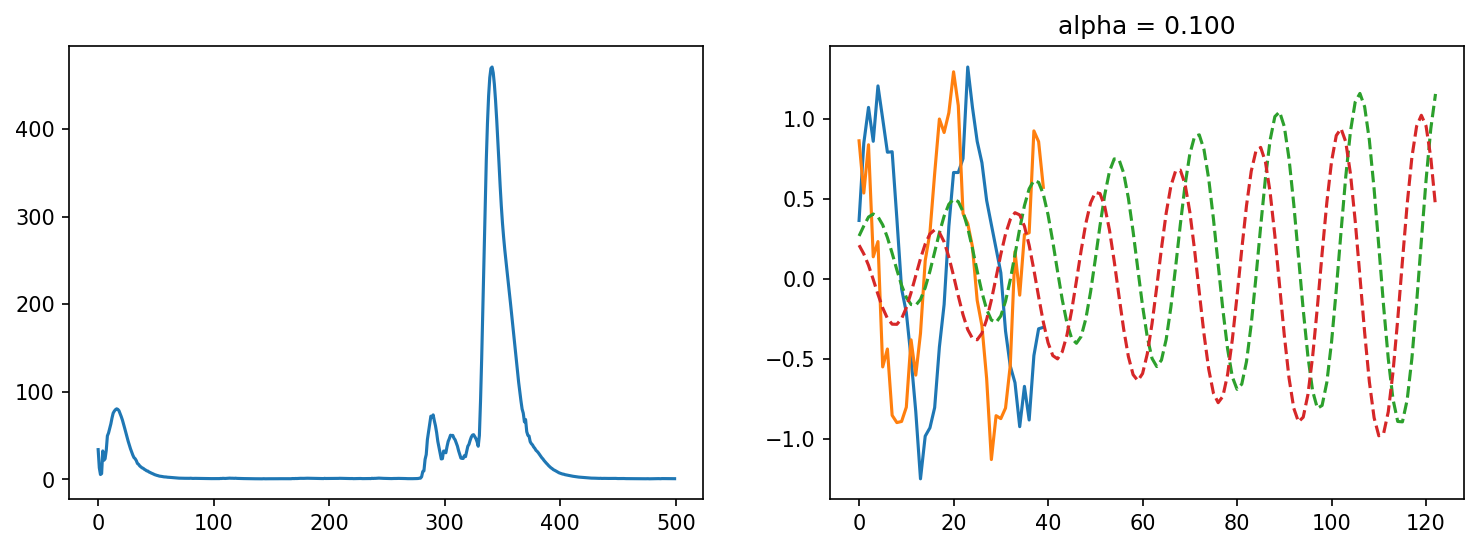

  0%|          | 0/500 [00:00<?, ?it/s]

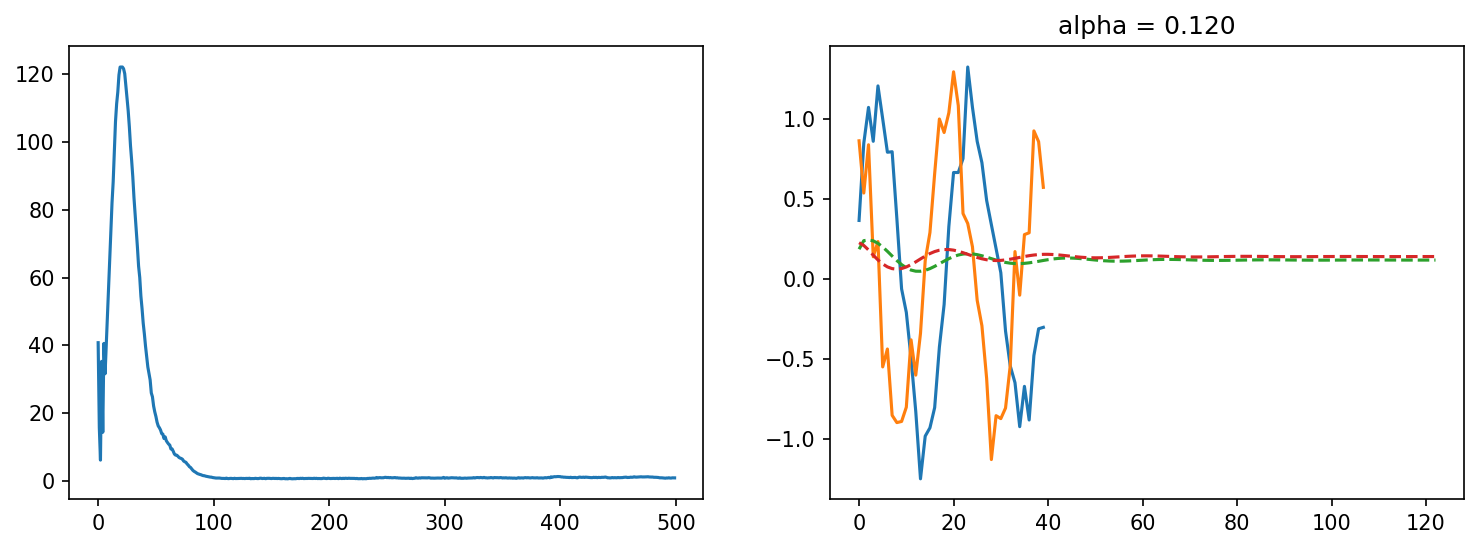

  0%|          | 0/500 [00:00<?, ?it/s]

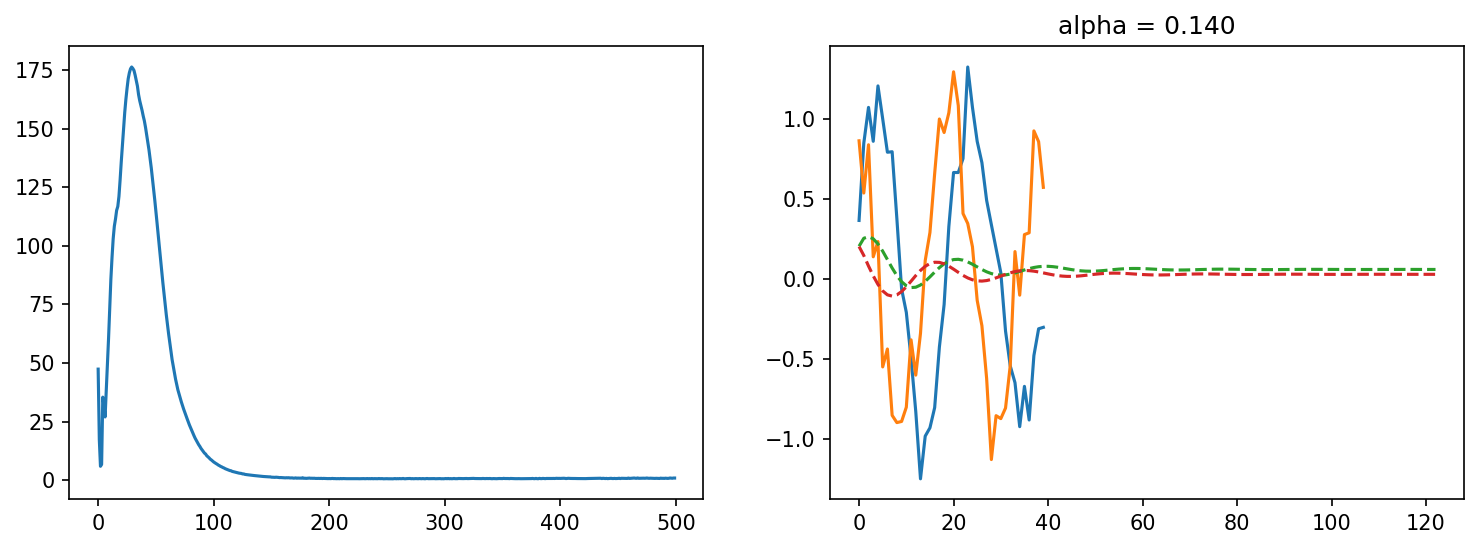

  0%|          | 0/500 [00:00<?, ?it/s]

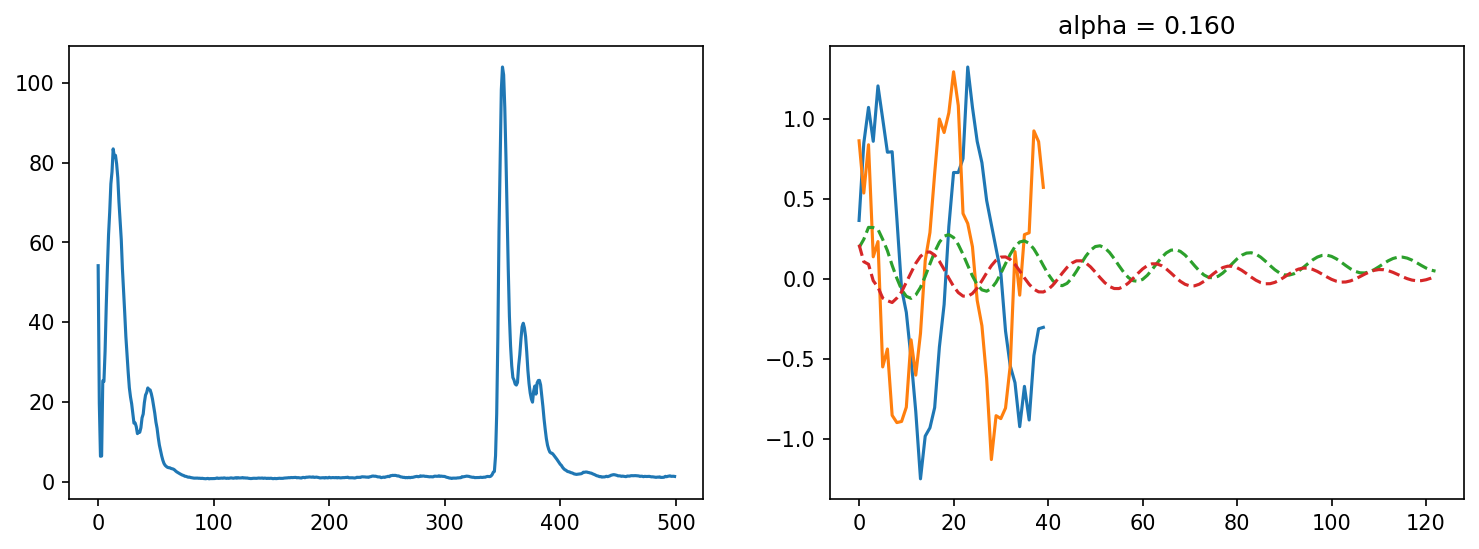

  0%|          | 0/500 [00:00<?, ?it/s]

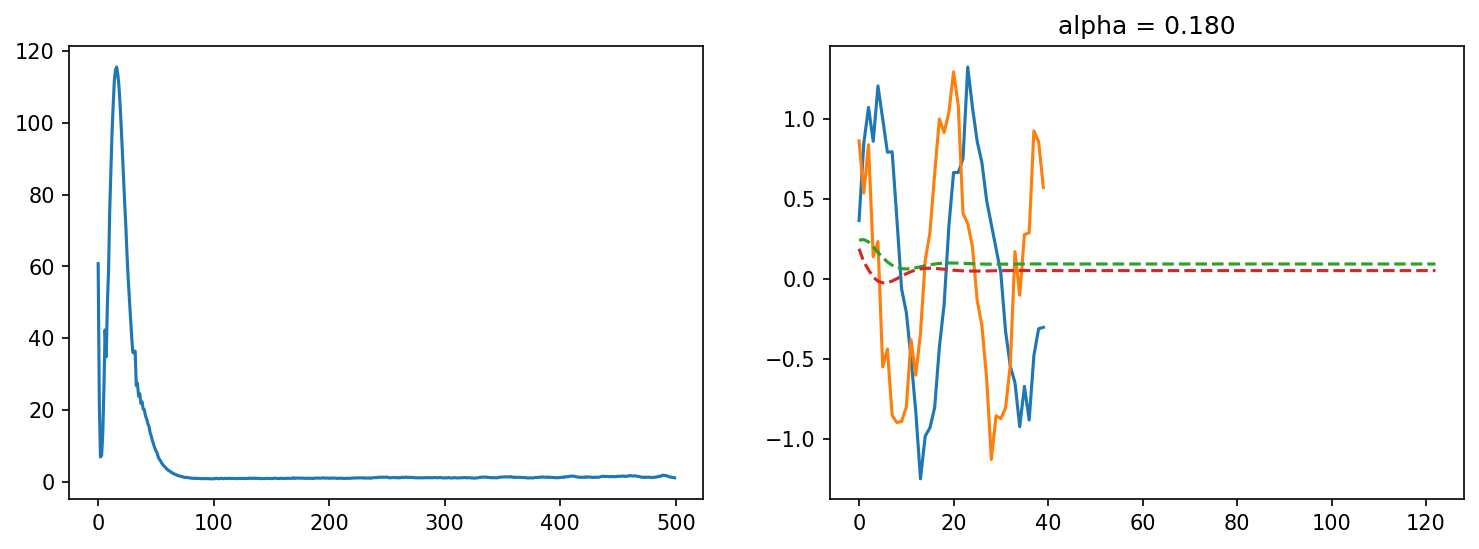

  0%|          | 0/500 [00:00<?, ?it/s]

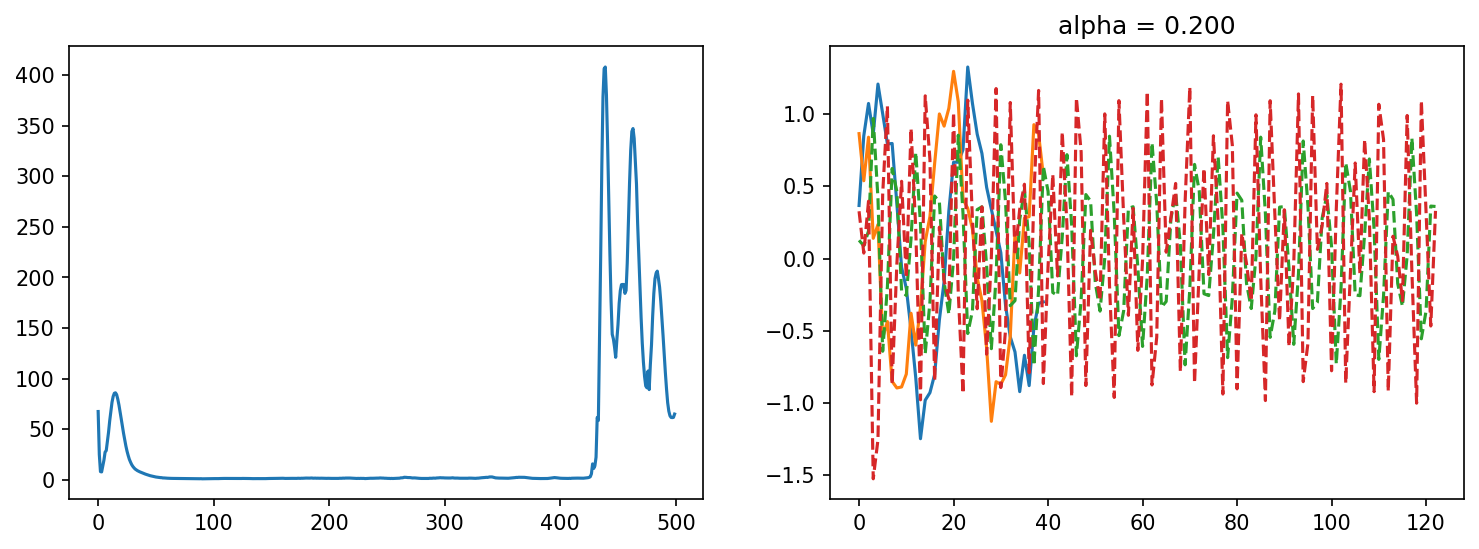

In [47]:
hidden_size = 1000
epochs = 500
learning_rate = 0.01
alphas = np.linspace(0, .2, 11)
for alpha in alphas:
    model = latent_RNN(observation_size, hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()
    loss_function = lambda output, target: mse_loss(output, target) + alpha * model.L2_regularization()

    losses = train(model, optimizer, loss_function, epochs, hidden_size, batch_size=16)

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(losses)
    
    with torch.no_grad():
        h = torch.zeros((1, hidden_size), device=device)
        predictions = torch.zeros((3*data.shape[0], observation_size))
        input_ = data[0:1].to(device)
        for i in range(3*data.size(0)):
            pred, h = model(input_, h)
            input_ = pred
            predictions[i] = pred.cpu()

        axes[1].plot(data[1:])
        axes[1].plot(predictions, "--")

    plt.title(f"alpha = {alpha:.3f}")
        
    plt.show()

## c) Dropout

  0%|          | 0/500 [00:00<?, ?it/s]

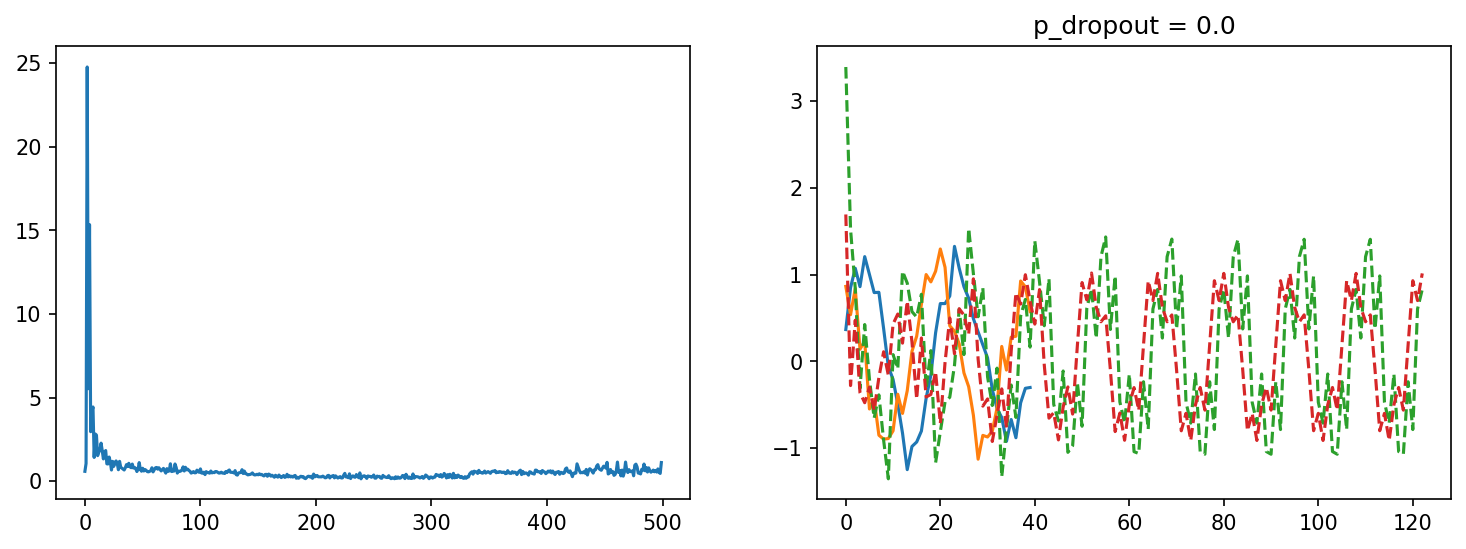

  0%|          | 0/500 [00:00<?, ?it/s]

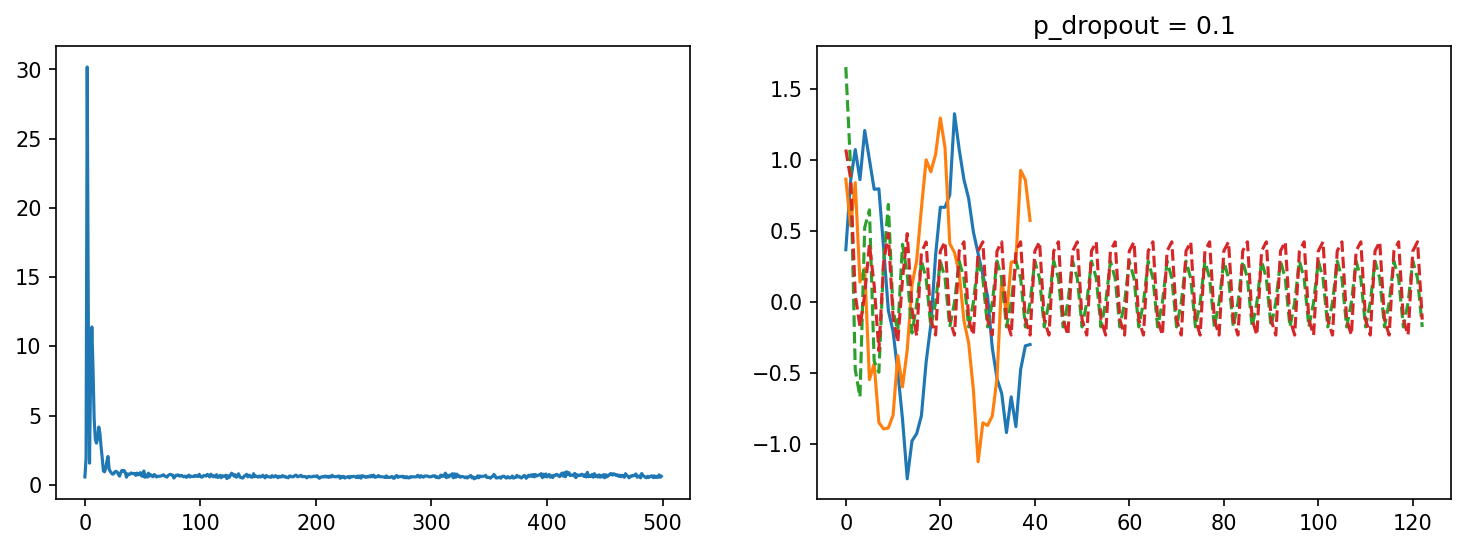

  0%|          | 0/500 [00:00<?, ?it/s]

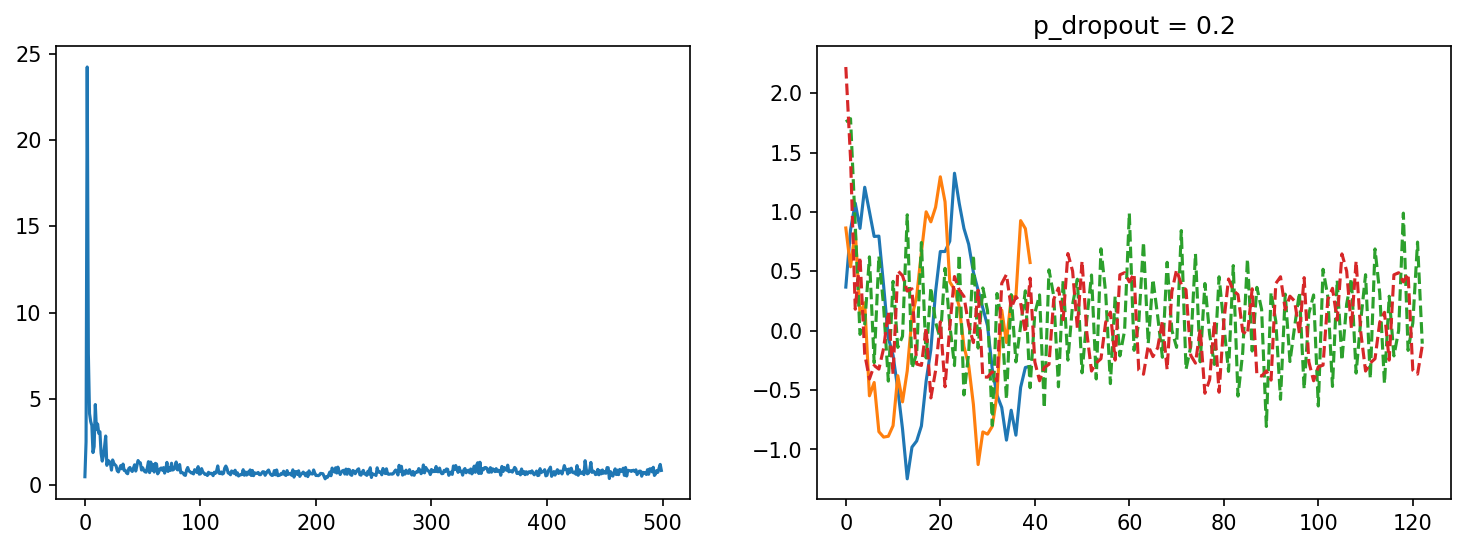

  0%|          | 0/500 [00:00<?, ?it/s]

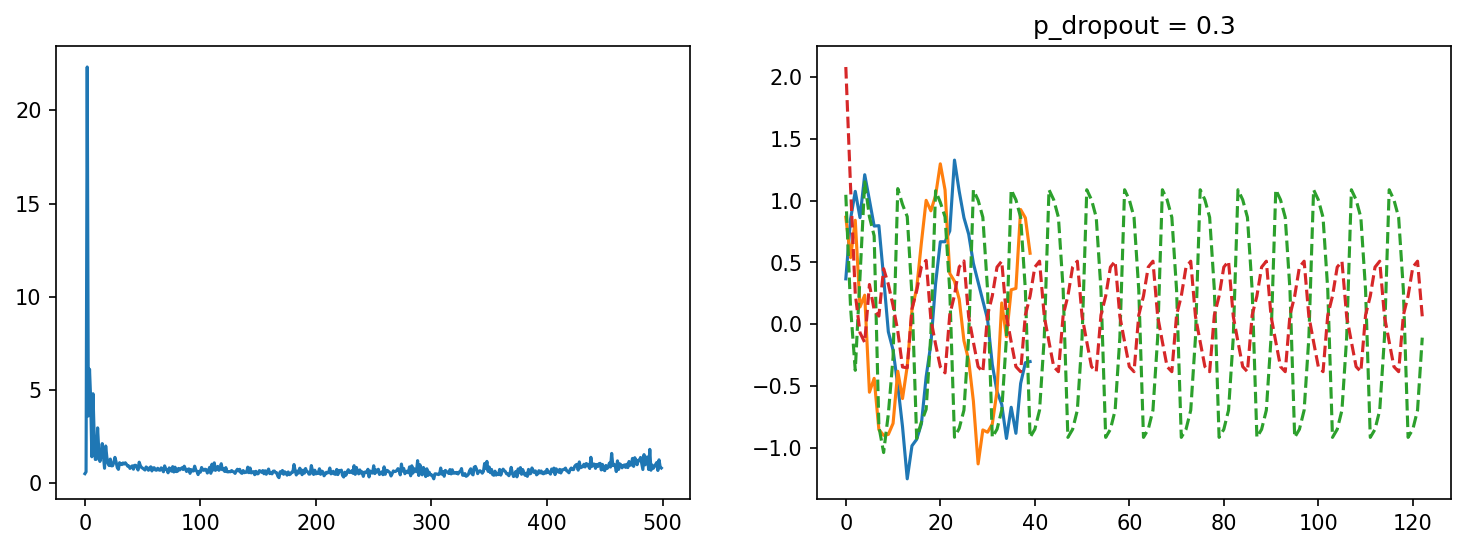

  0%|          | 0/500 [00:00<?, ?it/s]

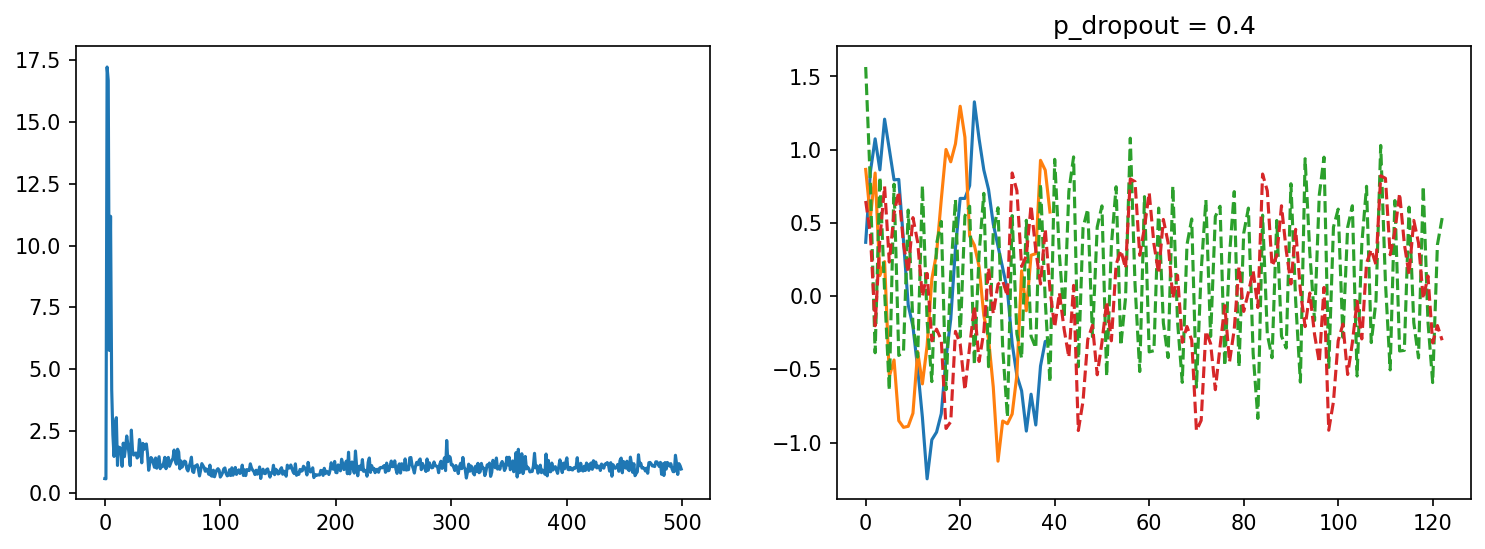

  0%|          | 0/500 [00:00<?, ?it/s]

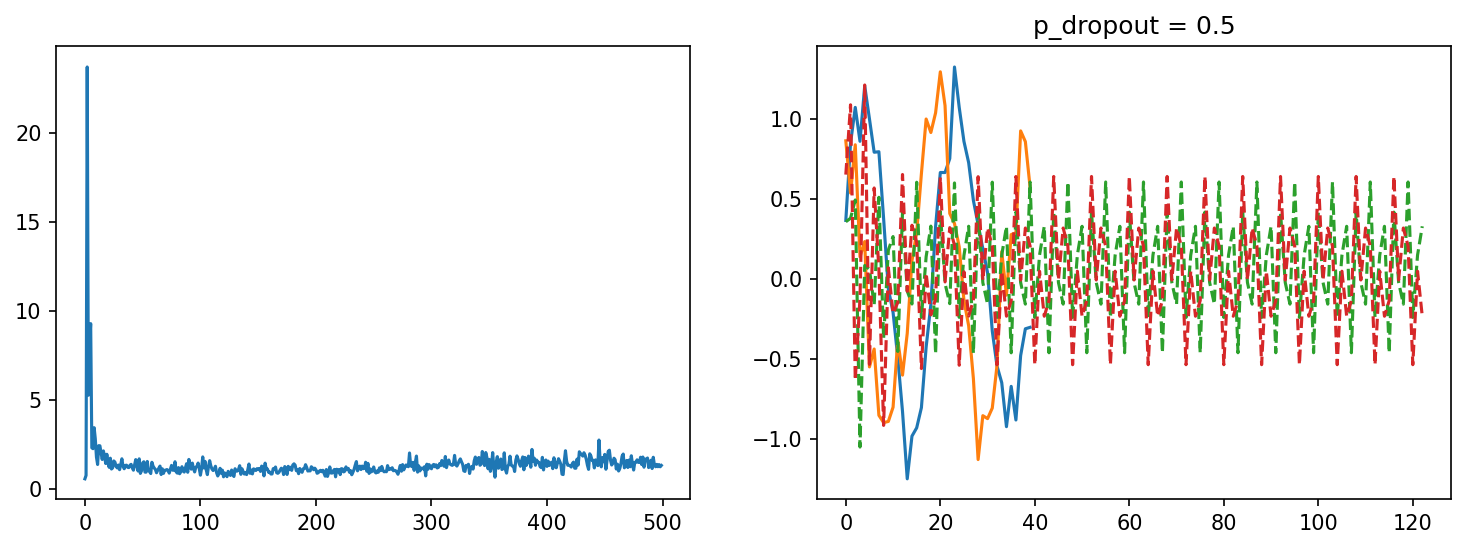

  0%|          | 0/500 [00:00<?, ?it/s]

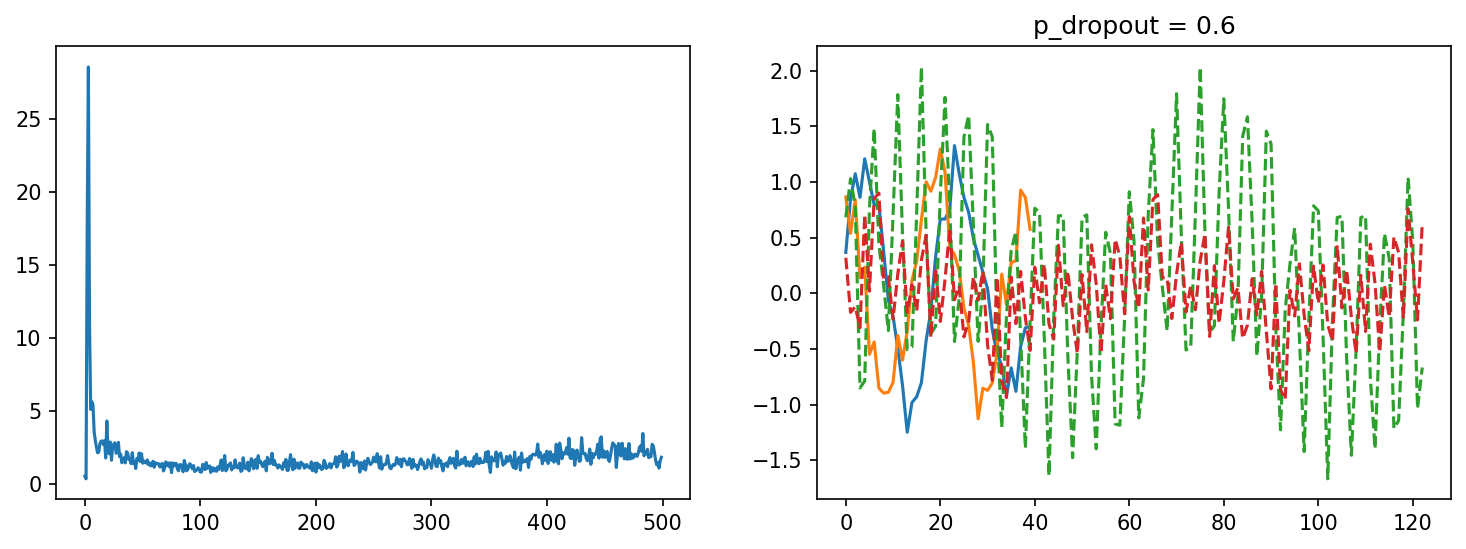

  0%|          | 0/500 [00:00<?, ?it/s]

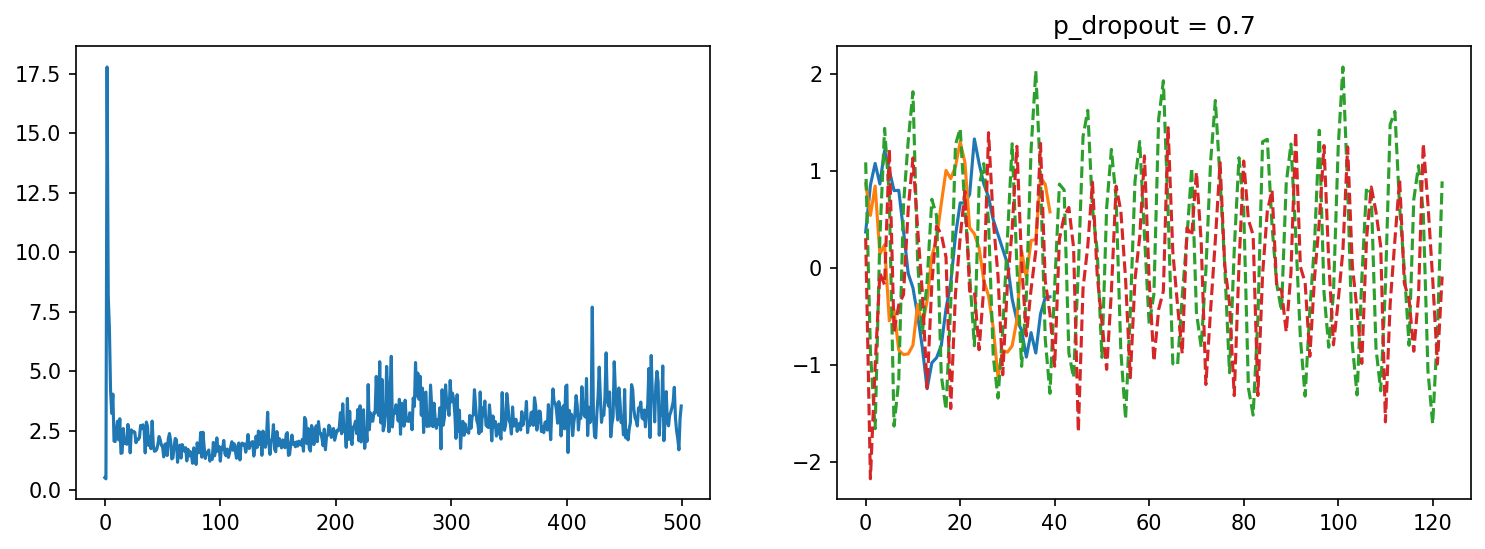

  0%|          | 0/500 [00:00<?, ?it/s]

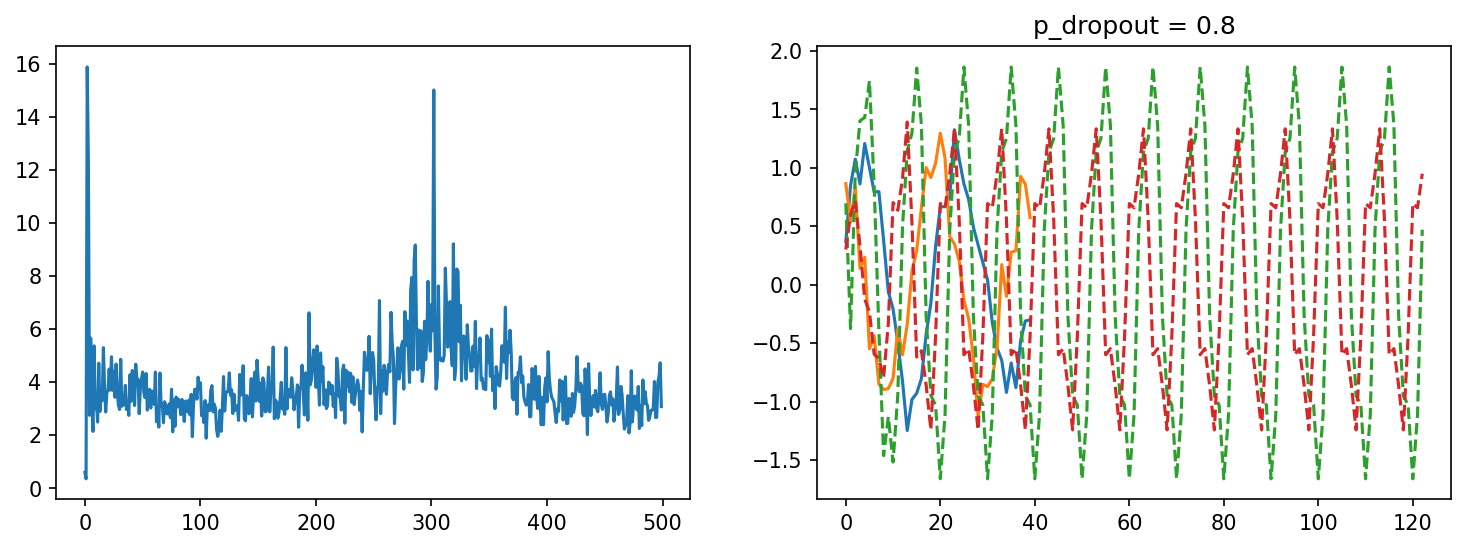

  0%|          | 0/500 [00:00<?, ?it/s]

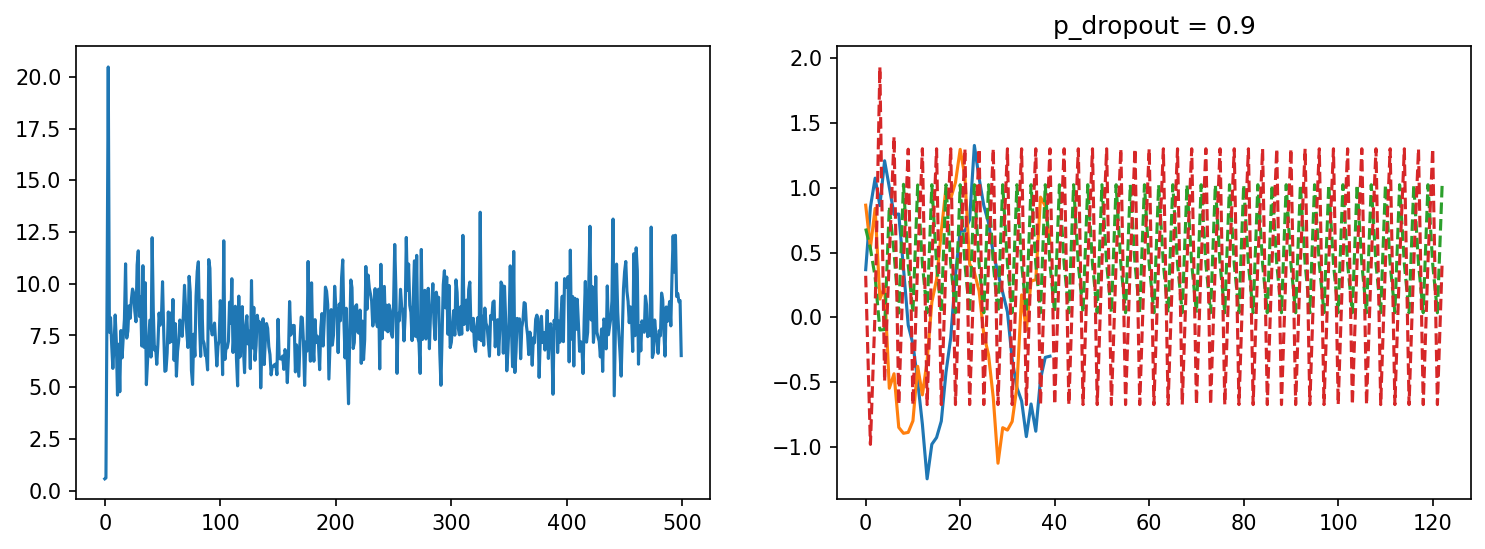

  0%|          | 0/500 [00:00<?, ?it/s]

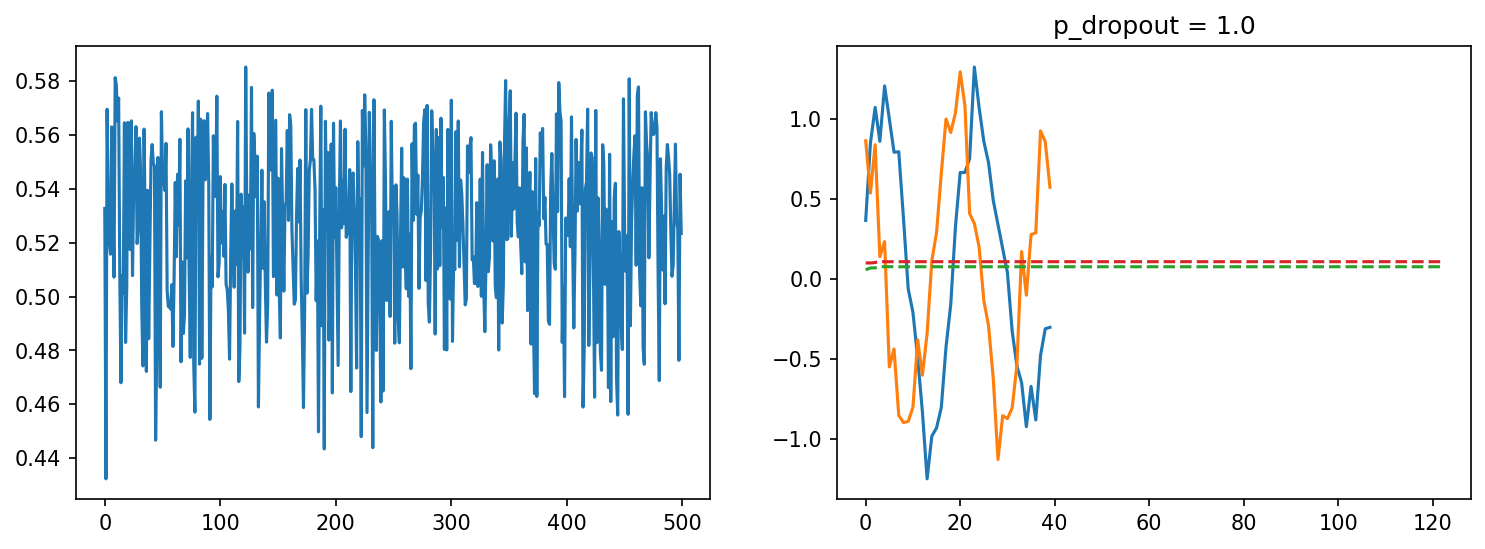

In [49]:
hidden_size = 1000
epochs = 500
learning_rate = 0.01
p_dropouts = np.linspace(0, 1, 11)
for p_dropout in p_dropouts:
    model = latent_RNN(observation_size, hidden_size, p_dropout=p_dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()

    model.train()
    losses = train(model, optimizer, loss_function, epochs, hidden_size, batch_size=16)
    model.eval()
    
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(losses)
    
    with torch.no_grad():
        h = torch.zeros((1, hidden_size), device=device)
        predictions = torch.zeros((3*data.shape[0], observation_size))
        input_ = data[0:1].to(device)
        for i in range(3*data.size(0)):
            pred, h = model(input_, h)
            input_ = pred
            predictions[i] = pred.cpu()

        axes[1].plot(data[1:])
        axes[1].plot(predictions, "--")

    plt.title(f"p_dropout = {p_dropout:.1f}")
        
    plt.show()